# 0.0. IMPORTS

In [33]:
import pandas              as pd
import numpy               as np
import seaborn             as sb
import matplotlib.pyplot   as plt
import xgboost             as xgb

import inflection
import math
import datetime
import random
import pickle

from scipy                         import stats    as ss
from boruta                        import BorutaPy
from tabulate                      import tabulate

from sklearn.preprocessing         import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics               import mean_absolute_error, mean_squared_error
from sklearn.ensemble              import RandomForestRegressor
from sklearn.linear_model          import LinearRegression, Lasso

from IPython.display import Image
from IPython.display import HTML

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

## 0.1. Helper Functions

In [5]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):

  mae_list = []
  mape_list = []
  rmse_list = []

  for k in reversed( range(1, kfold+1 ) ):

    if verbose:
      print( f'\nKFold Number: {k}' )

    # start and end date for validation 
    validation_start_date = x_training[ 'date' ].max() - datetime.timedelta( days=k*6*7 )
    validation_end_date = x_training[ 'date' ].max() - datetime.timedelta( days=(k-1)*6*7 )

    # filtering dataset
    training = x_training[x_training['date'] < validation_start_date]
    validation = x_training[ (x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date) ]

    # training and validation dataset
    # training
    xtraining = training.drop( ['date', 'sales'], axis=1 )
    ytraining = training['sales']

    # validation
    xvalidation = validation.drop( ['date', 'sales'], axis=1 )
    yvalidation = validation['sales']

    # model
    m = model.fit( xtraining, ytraining )

    # prediction
    yhat = m.predict( xvalidation )

    # performance
    model_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

    # store performance of each kfold iteration
    mae_list.append(  model_result['MAE']  )
    mape_list.append( model_result['MAPE'] )
    rmse_list.append( model_result['RMSE'] )

  return pd.DataFrame(  { 'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


def mean_absolute_percentage_error( y_pred, yhat ):
    return np.mean( np.abs( ( y_pred - yhat ) / y_pred ) )

def ml_error( model_name, y_pred, yhat ):
    mae = mean_absolute_error( y_pred, yhat )
    mape = mean_absolute_percentage_error( y_pred, yhat )
    rmse = np.sqrt( mean_squared_error( y_pred, yhat ) )
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index=[0] )

def cramer_v( x, y ):
    
    cm = pd.crosstab( x, y ).to_numpy()
    
    n = cm.sum()
    
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0 , chi2 - ( k-1 ) * ( r-1 ) / ( n-1 ) )
    
    kcorr = k - ( k-1 )**2 / ( n-1 )
    rcorr = r - ( r-1 )**2 / ( n-1 )
    

    return np.sqrt( ( chi2corr/n ) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings():
  
    %matplotlib inline
    %pylab inline
  
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
  
    display( HTML( '<style>.container { width: 100% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
  
    sb.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


/media/ronaldo/HD/Python Projects/Projetos de Portifólio/Rossmann Sales Prediction/venv/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


'/usr/src/app/datasets'

## 0.2. Loading Data

In [8]:
df_sales_raw = pd.read_csv('train_rossmann.csv', low_memory=False)
df_store_raw = pd.read_csv('store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. DATA DESCRIPTION

In [9]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [10]:
old_columns = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

new_columns = list( map(snakecase, old_columns) )

#rename
df1.columns = new_columns

## 1.2. Data Dimensions

In [11]:
print( f'Number of rows: {df1.shape[0]}')
print( f'Number of columns: {df1.shape[1]}')

Number of rows: 1017209
Number of columns: 18


## 1.3. Data Types

In [12]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [13]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. FIllout NA

There are various approaches to performing the filling of missing values, but in this project, I used a method of filling that considers the business aspect. I do not have expertise in the sales area, therefore, not all replacements may be the most appropriate.

In [14]:
# competition_distance
max_distance_value = 200000.0
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: max_distance_value if math.isnan(x) else x)

# competition_open_since_month  
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year  
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week    
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year               
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


In [15]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [16]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7. Descriptive Statistical

Statistical description is very important for gaining business knowledge and being able to identify errors in the data we are working with.

In [17]:
# select numercial columns
num_attributes = df1.select_dtypes(include=['int64', 'float64', ])

# select categorical columns
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [18]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
metrics = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
metrics.columns = (['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])

In [19]:
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


## 1.7.2. Categorical Attributes

In [20]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

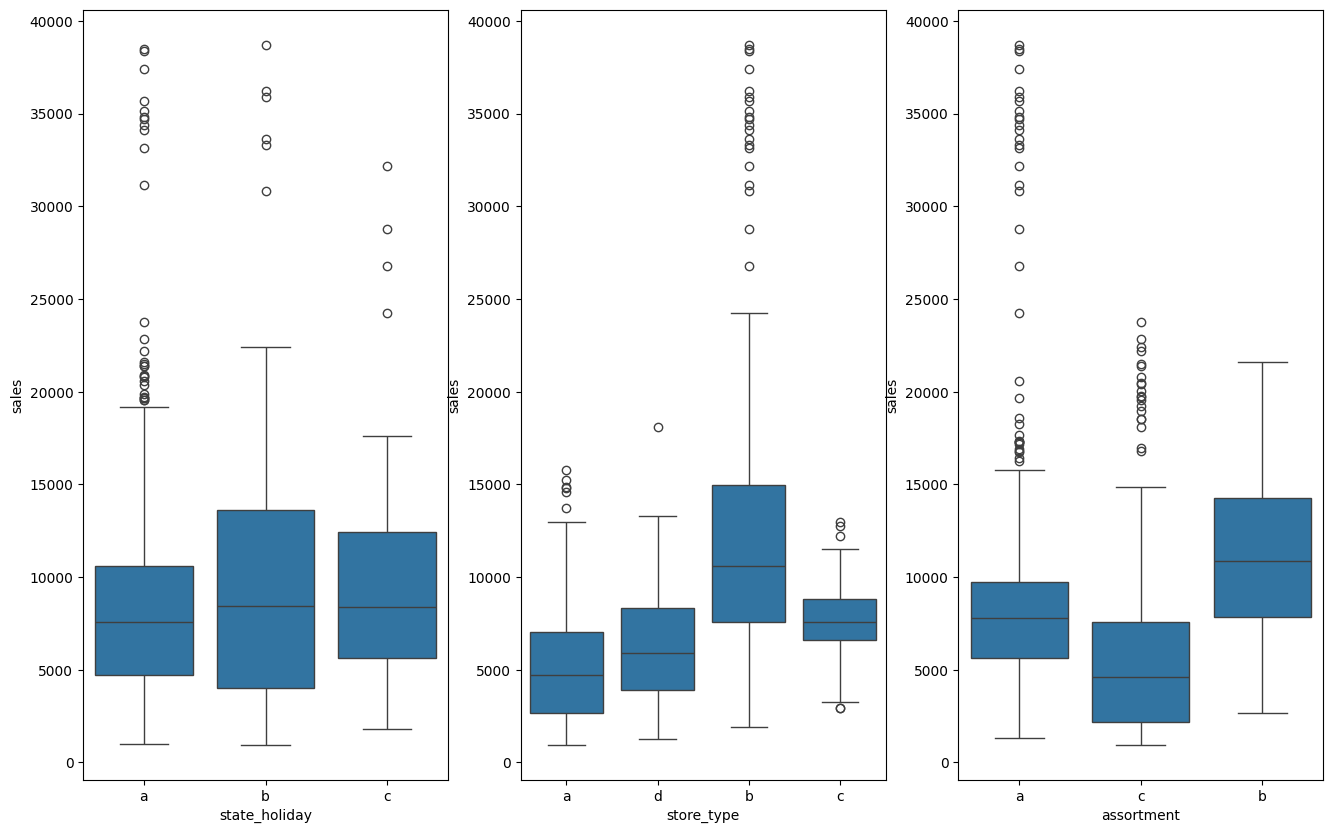

In [21]:
# filter only important datas
aux1 = df1[( df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 )]

plt.figure( figsize=( 16, 10 ) )
plt.subplot( 1, 3, 1)
sb.boxplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot( 1, 3, 2)
sb.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot( 1, 3, 3)
sb.boxplot( x='assortment', y='sales', data=aux1 )

# 2.0. FEATURE ENGINEERING

In [22]:
df2 = df1.copy()

Hypothesis for Stores

2.1.1. Store Hypotheses
1. Stores with more staff should sell more.

2. Stores with larger inventories should sell more.

3. Larger stores should sell more.

4. Smaller stores should sell less.

5. Stores with a larger assortment of products should sell more.

6. Stores with closer competitors should sell less.

7. Stores with long-standing competitors should sell more.

2.1.2. Product Hypotheses
8. Stores that invest more in marketing should sell more.

9. Stores that display products more prominently in windows should sell more.

10. Stores with lower-priced products should sell more.

11. Stores that maintain lower prices over a longer period should sell more.

12. Stores with more "aggressive" promotions should sell more.

13. Stores with longer active promotions should sell more.

14. Stores with more promotion days should sell more.

15. Stores with more consecutive promotions should sell more.

2.1.3. Temporal Hypotheses
16. Stores that are open during the Christmas holiday should sell more.

17. Stores should sell less on weekends.

18. Stores should sell more over the years.

19. Stores should sell more in the second half of the year.

20. Stores should sell more after the 10th of each month.

21. Stores should sell less during school holidays.

2.2. Final Hypothesis List
Hypotheses that can be answered based on the available dataset. In a real environment, missing information would be requested from the data engineering team to provide some important variables to answer the other hypotheses.

5. Stores with a larger assortment of products should sell more.

6. Stores with closer competitors should sell less.

7. Stores with long-standing competitors should sell more.

13. Stores with longer active promotions should sell more.

14. Stores with more promotion days should sell more.

15. Stores with more consecutive promotions should sell more.

16. Stores that are open during the Christmas holiday should sell more.

17. Stores should sell less on weekends.

18. Stores should sell more over the years.

19. Stores should sell more in the second half of the year.

20. Stores should sell more after the 10th of each month.

21. Stores should sell less during school holidays.

## 2.3. Feature Engineering

In [25]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1)
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/ 7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if  x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if  x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

# 3.0. FILTERING VARIABLES

In [26]:
df3 = df2.copy()

## 3.1. Filtering Rows

In [27]:
df3 = df3[( df3['open'] != 0 ) & ( df3['sales'] > 0 )]

## 3.2 Columns Selection

In [28]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

# 4.0. EXPLORATORY DATA ANALYSIS

In [29]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

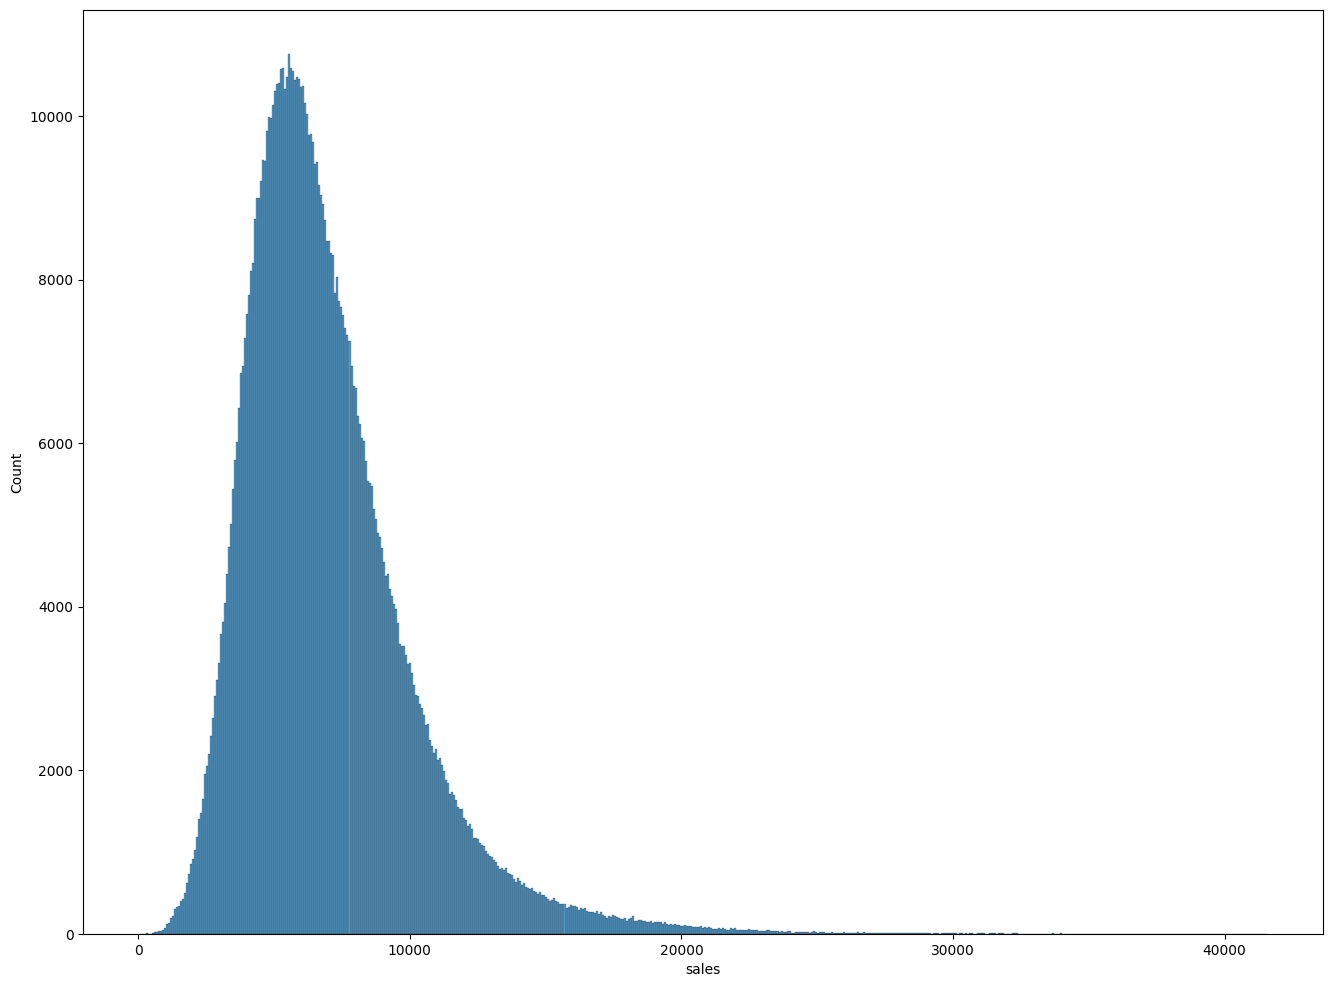

In [30]:
plt.rcParams['figure.figsize'] = [16, 12]
sb.histplot( df4['sales'] );

### 4.1.2. Numerical Variable

Analyzing the chart below of the numeric variables, it can be observed that the **day_of_week** feature does not show variations, meaning that the stores sold basically the same amount every day of the week, therefore, this feature will not be relevant for the model. Other features presented important information for the business, such as **is_promo**, in which it was noticed that there were more sales of products that were not on promotion, which could be an insight for the business team.

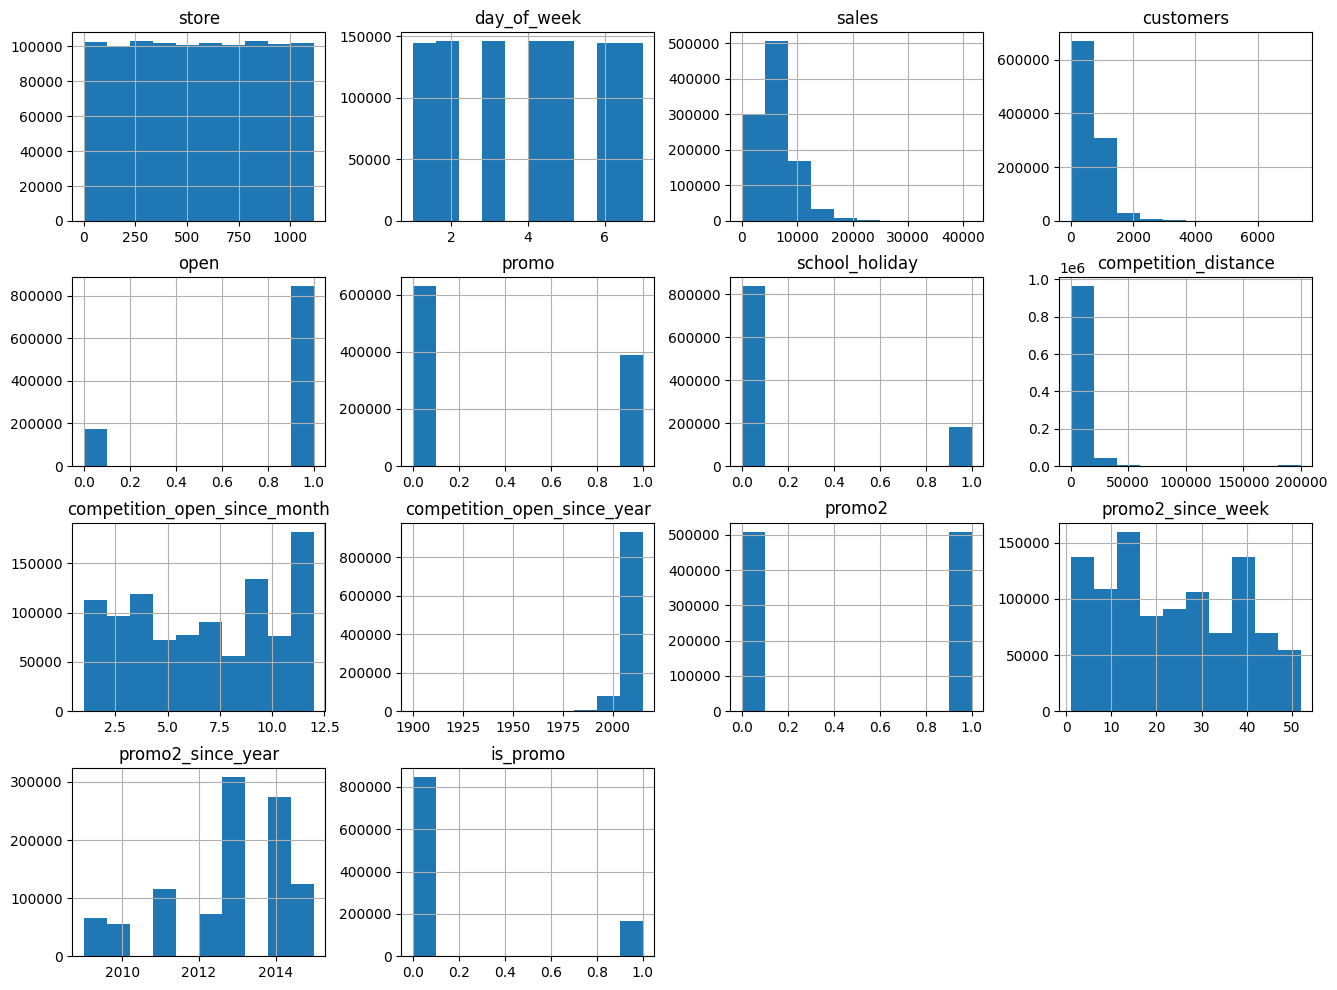

In [31]:
num_attributes.hist();

### 4.1.3. Categorical Variable

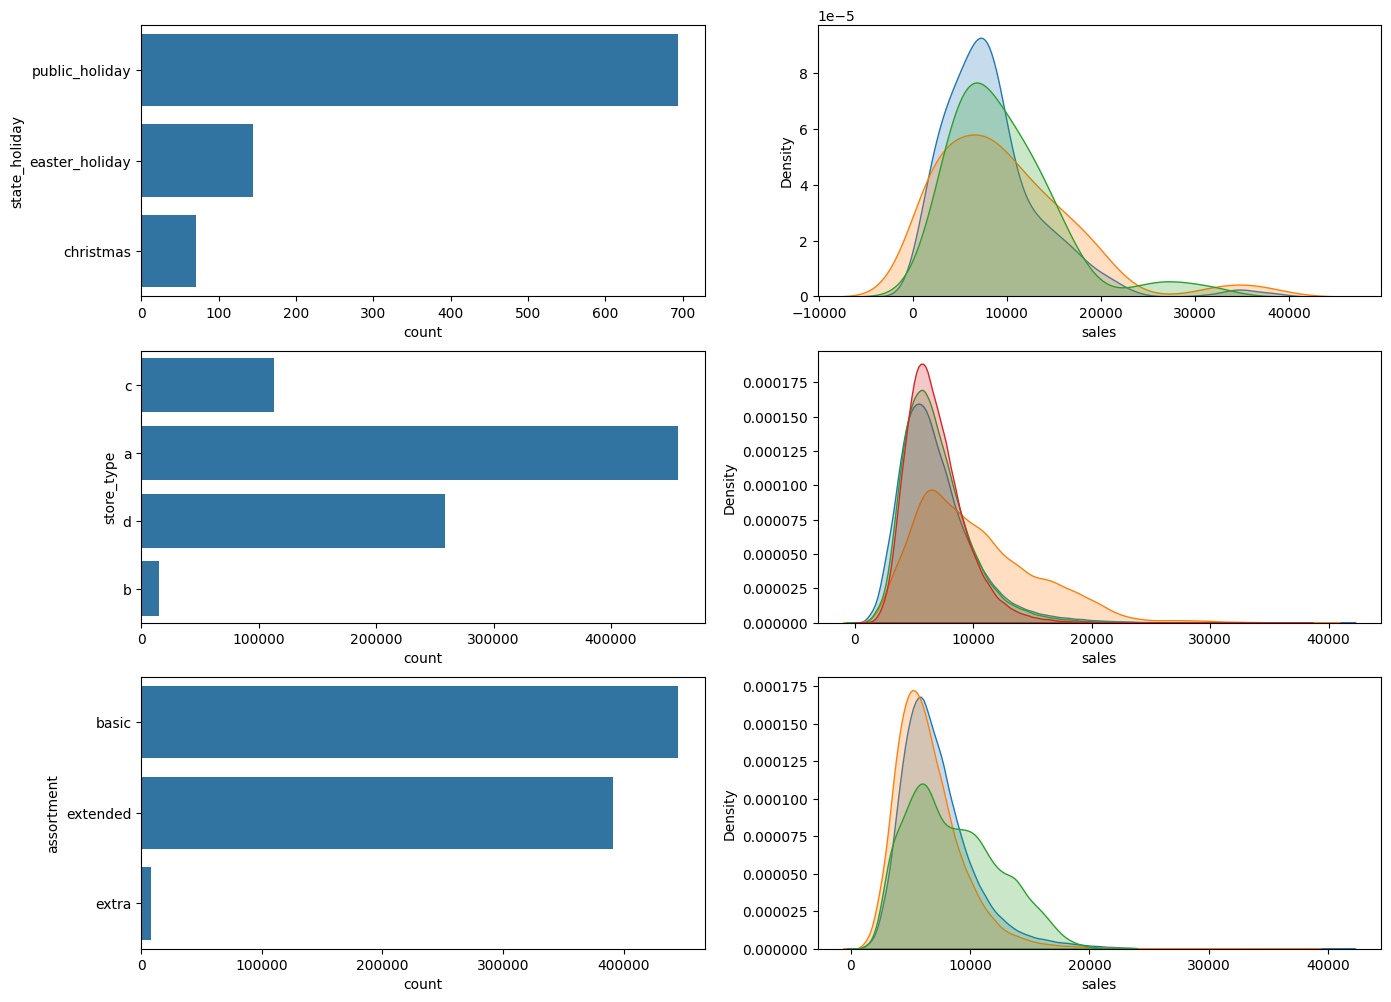

In [34]:
# state_holiday
plt.subplot( 3, 2, 1 )
aux1 = df4[df4['state_holiday'] != 'regular_day']
sb.countplot( aux1['state_holiday'] )

plt.subplot( 3, 2, 2 )
sb.kdeplot( data=df4[df4['state_holiday'] == 'public_holiday']['sales'], shade=True );
sb.kdeplot( data=df4[df4['state_holiday'] == 'easter_holiday']['sales'], shade=True );
sb.kdeplot( data=df4[df4['state_holiday'] == 'christmas']['sales'], shade=True );

# store_type
plt.subplot( 3, 2, 3 )
sb.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sb.kdeplot( data=df4[df4['store_type'] == 'a']['sales'], shade=True );
sb.kdeplot( data=df4[df4['store_type'] == 'b']['sales'], shade=True );
sb.kdeplot( data=df4[df4['store_type'] == 'c']['sales'], shade=True );
sb.kdeplot( data=df4[df4['store_type'] == 'd']['sales'], shade=True );

# assortment
plt.subplot( 3, 2, 5 )
sb.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sb.kdeplot( data=df4[df4['assortment'] == 'extended']['sales'], shade=True );
sb.kdeplot( data=df4[df4['assortment'] == 'basic']['sales'], shade=True );
sb.kdeplot( data=df4[df4['assortment'] == 'extra']['sales'], shade=True );

## 4.2. Bivariate Analysis

### **H5.** Stores with a larger assortment of products should sell more.

**False**. According to the chart below, it is observed that stores with more assortment are the ones that sell less.

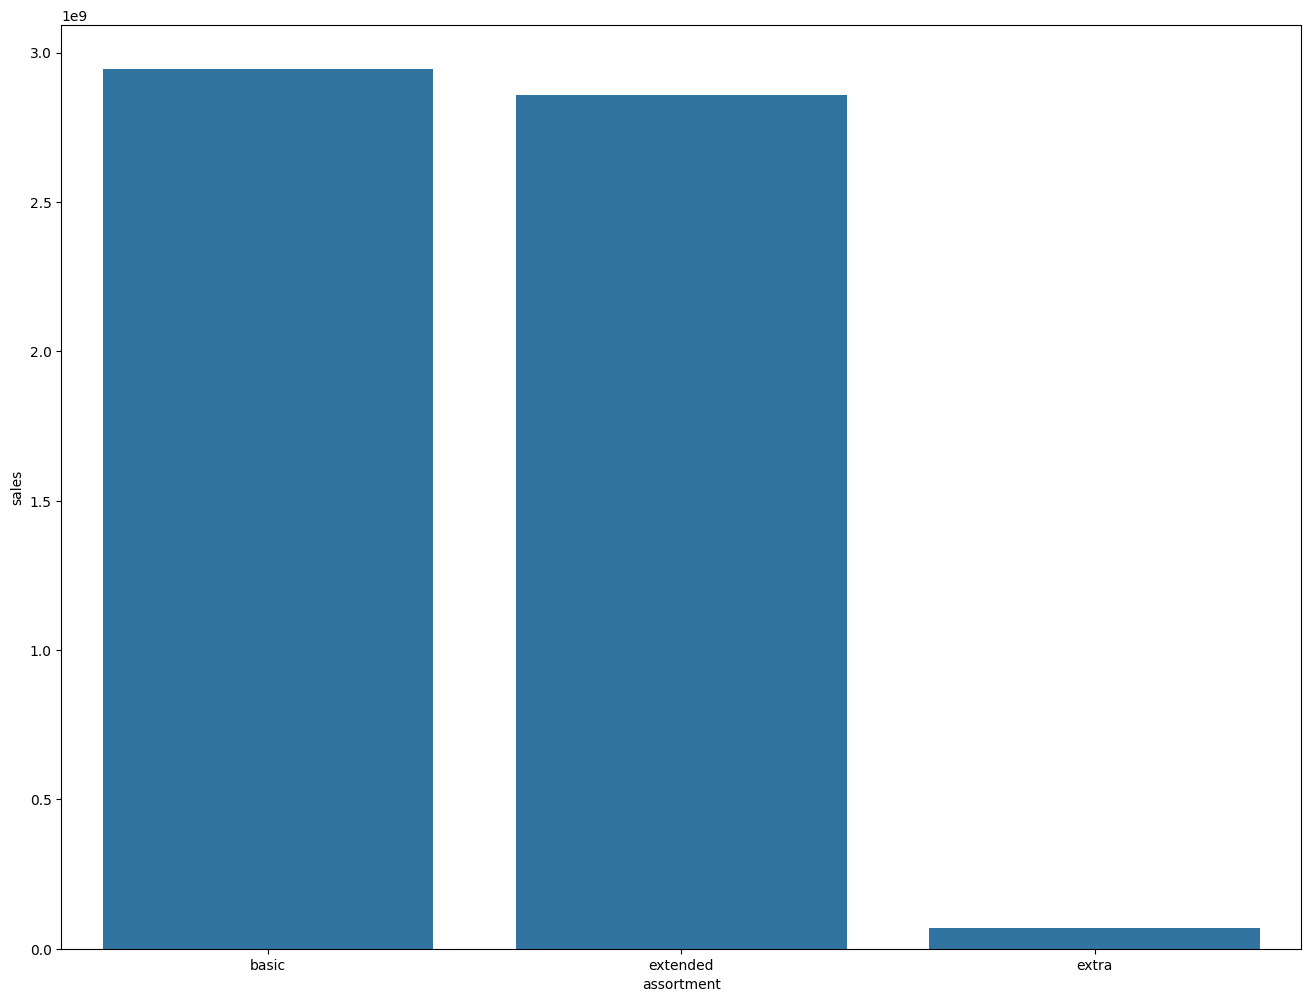

In [35]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sb.barplot( x='assortment', y='sales', data=aux1 );

To conduct a more in-depth inspection of this hypothesis, the initial desire is to find out if stores with a larger assortment sold more in the past than they do currently. However, analyzing the second temporal chart, it is noticed that the **extra** assortment fluctuated significantly over time, which was not identifiable in the first chart. Analyzing the first chart, it was observed that the **basic** and **extended** assortments are very similar, but when viewing the set of these three variables together, they will be relevant for the model.

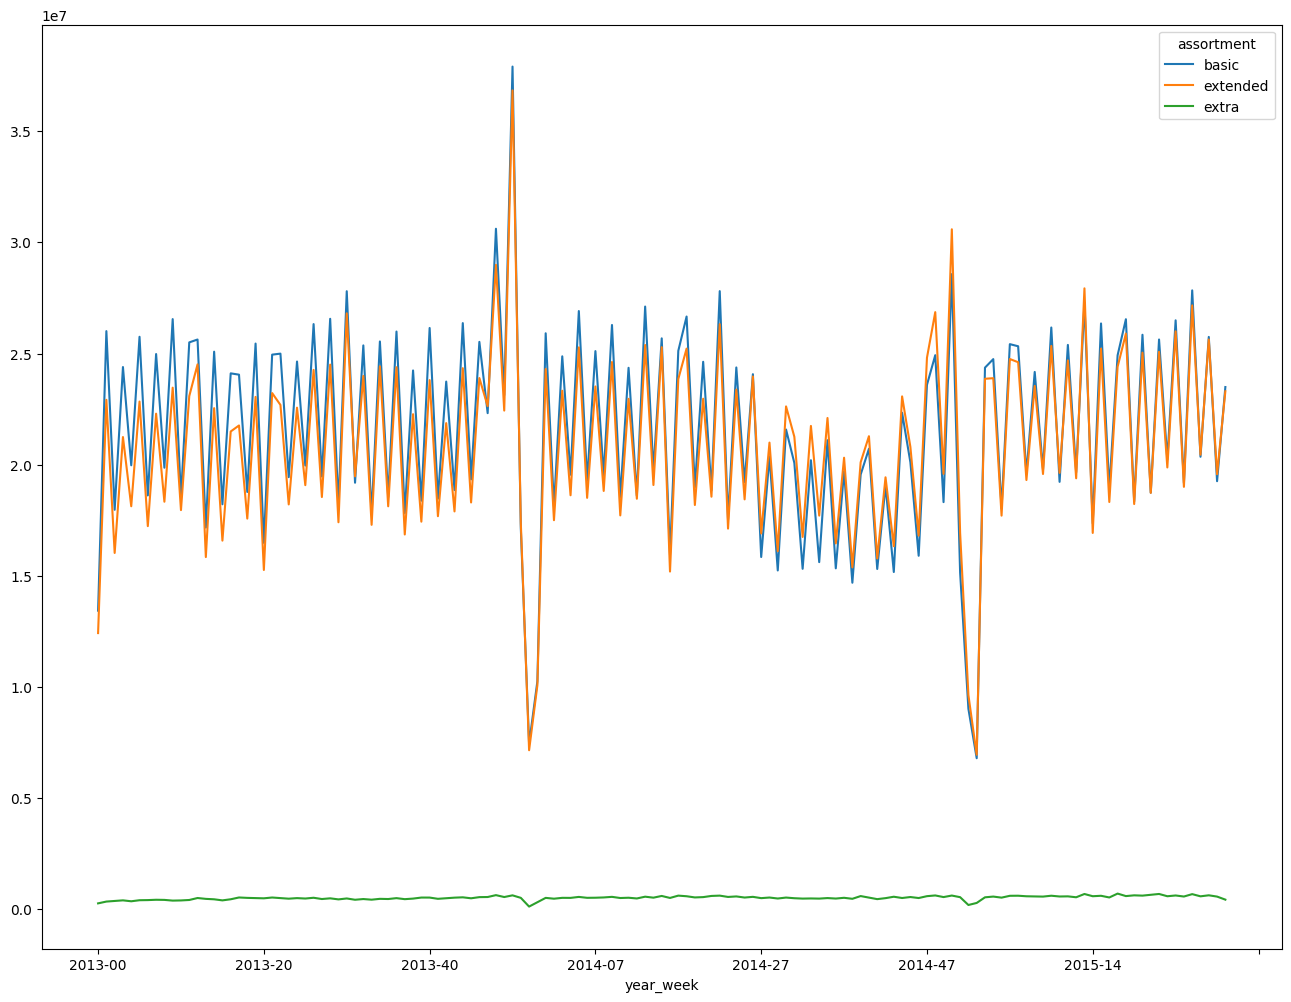

In [36]:
aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot();

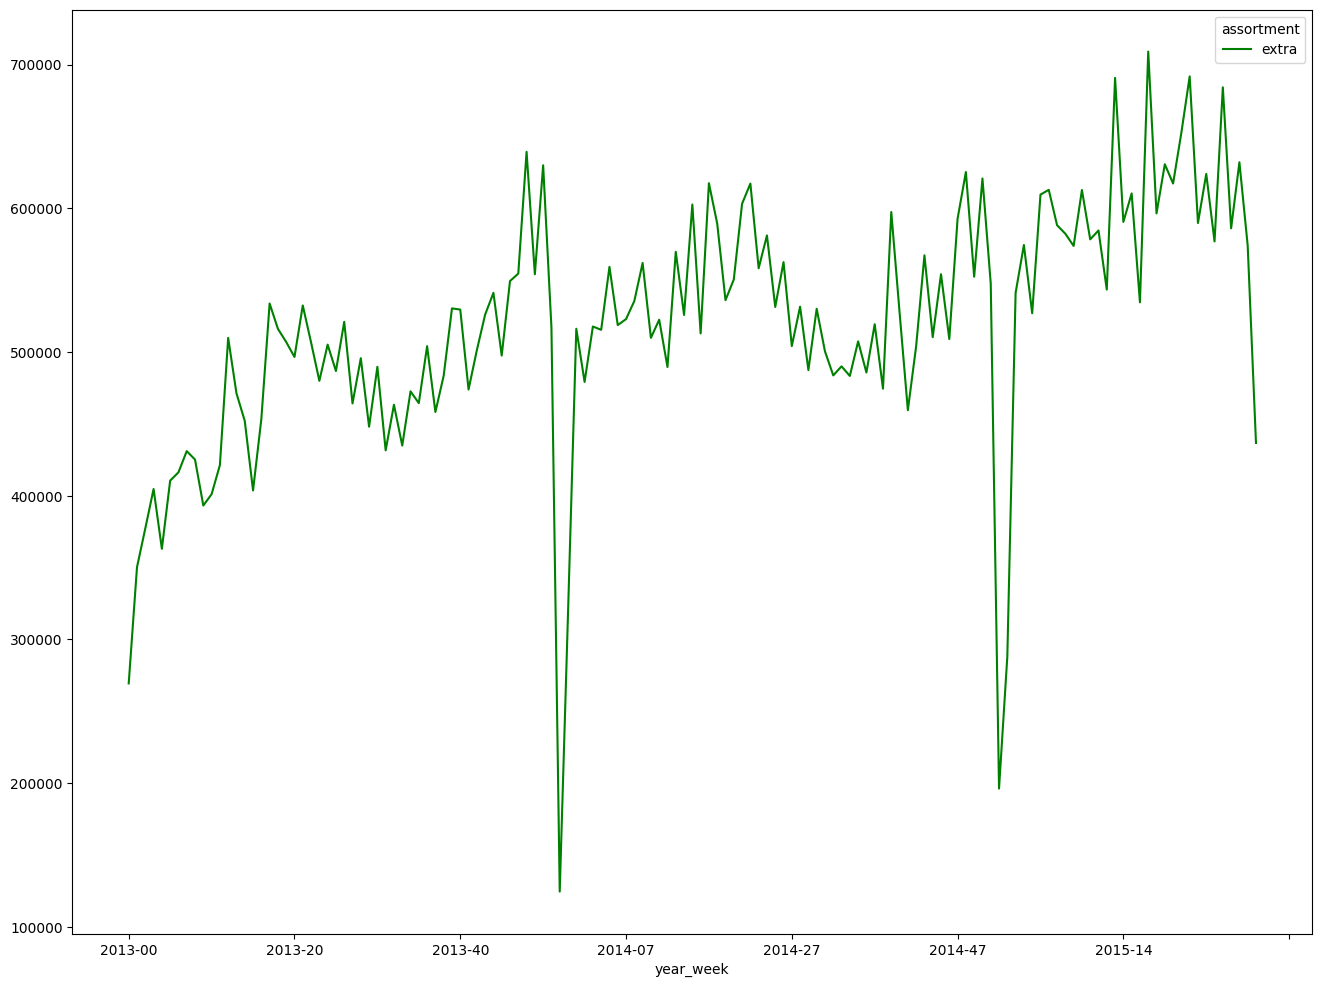

In [37]:
aux3 = df4[df4['assortment'] == 'extra']
aux3 = aux3[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot(color='green');

### **H6.** Stores with closer competitors should sell less.

**False**. Analyzing the charts below, it is observed that stores with nearby competitors sell more than those with more distant competitors. This is truly intriguing and somewhat deviates from the common sense notion that "the greater the competition, the lower the sales." It is very likely that this is a relevant insight for the business.

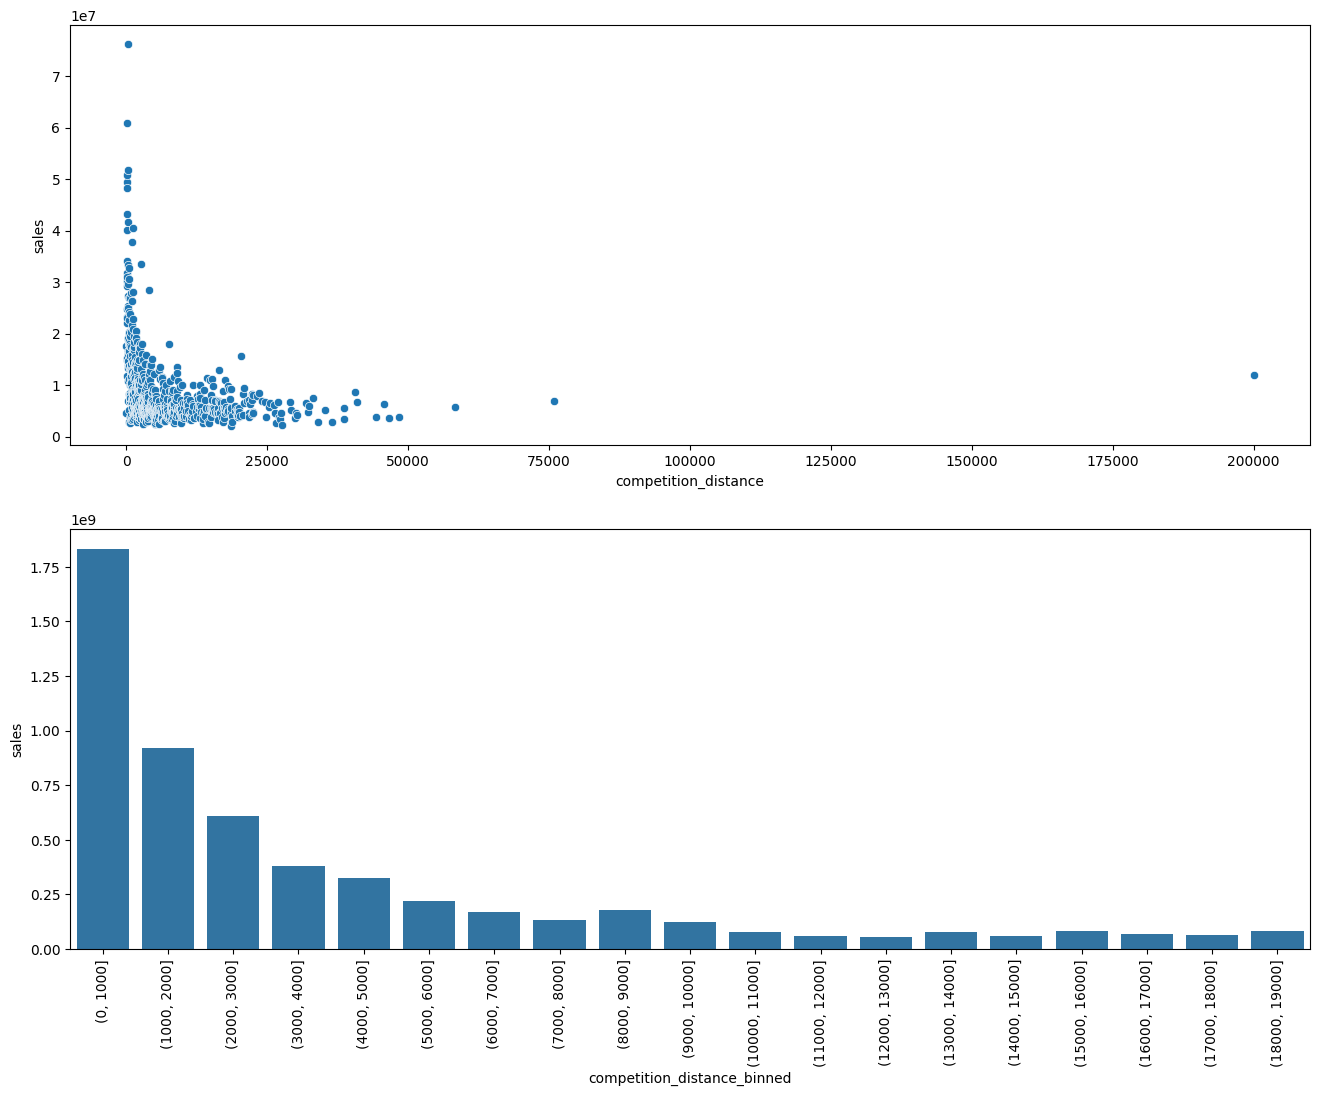

In [38]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

# agroup competition distance
bins = list( np.arange(0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()

# scatter plot
plt.subplot(2, 1, 1)
sb.scatterplot( x='competition_distance', y='sales', data=aux1 );

plt.subplot(2, 1, 2)
plt.xticks(rotation=90)
sb.barplot( x='competition_distance_binned', y='sales', data=aux2 );

To infer the correlation of the feature with the response variable, a heatmap was used. From this, it can be observed that this variable alone has a certain correlation with sales.

In [40]:
#sb.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H7.** Stores with long-standing competitors should sell more.

**False**. Analyzing the chart below, it is observed that the more recent the competition, the higher the sales, which is also quite intriguing. Therefore, stores with long-standing competitors sell less.

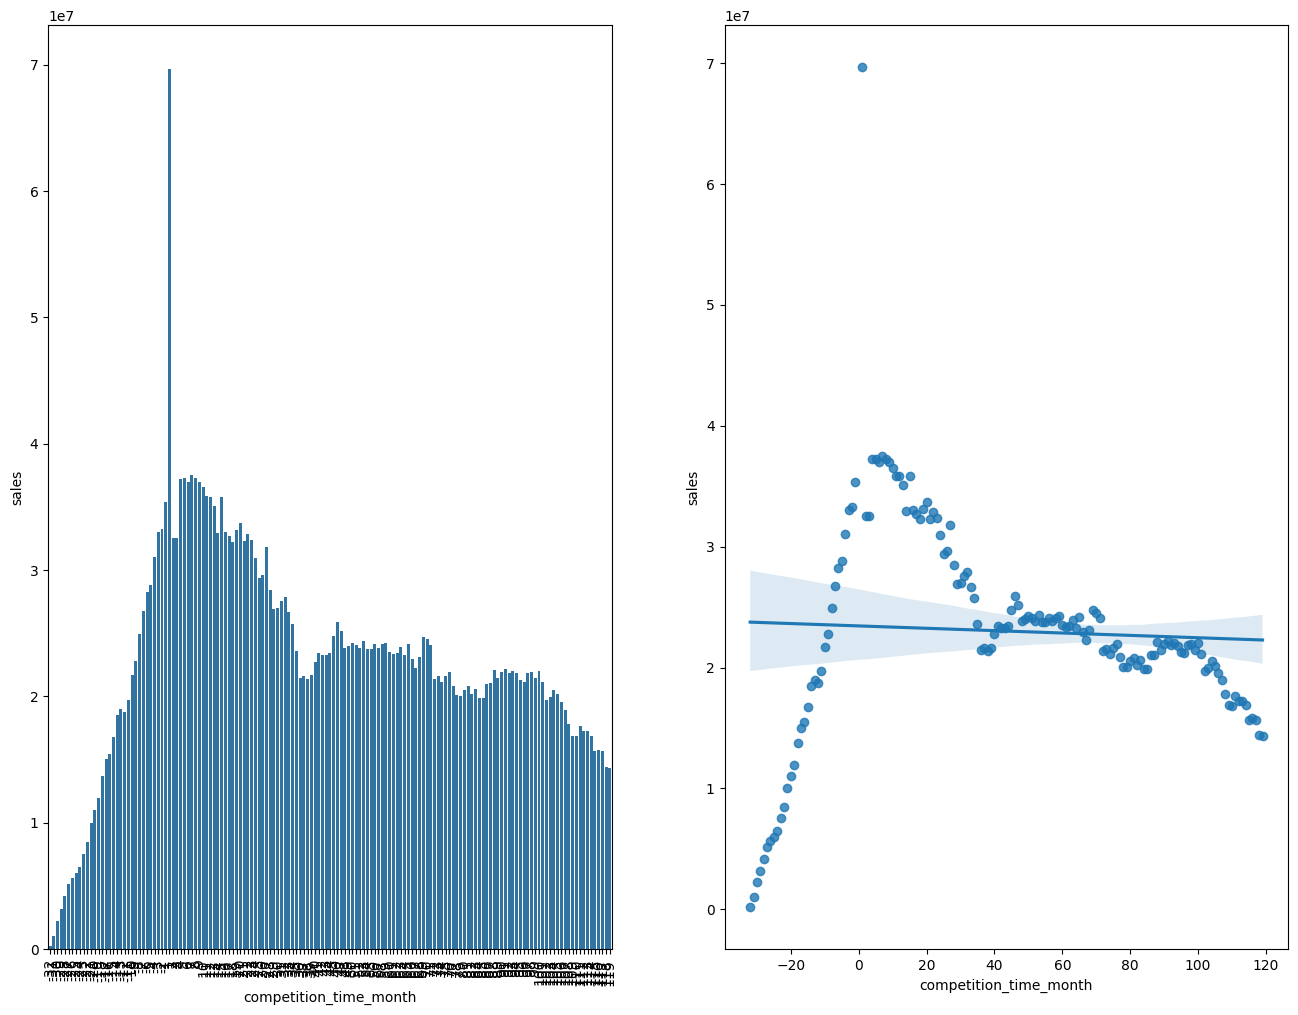

In [41]:
plt.subplot( 1 , 2, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
plt.xticks(rotation=90)
sb.barplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 2, 2 )
sb.regplot( x='competition_time_month', y='sales', data=aux2 );

To infer the correlation of the feature with the response variable, a heatmap was used. From this, it is observed that this variable alone has a weak correlation with sales.

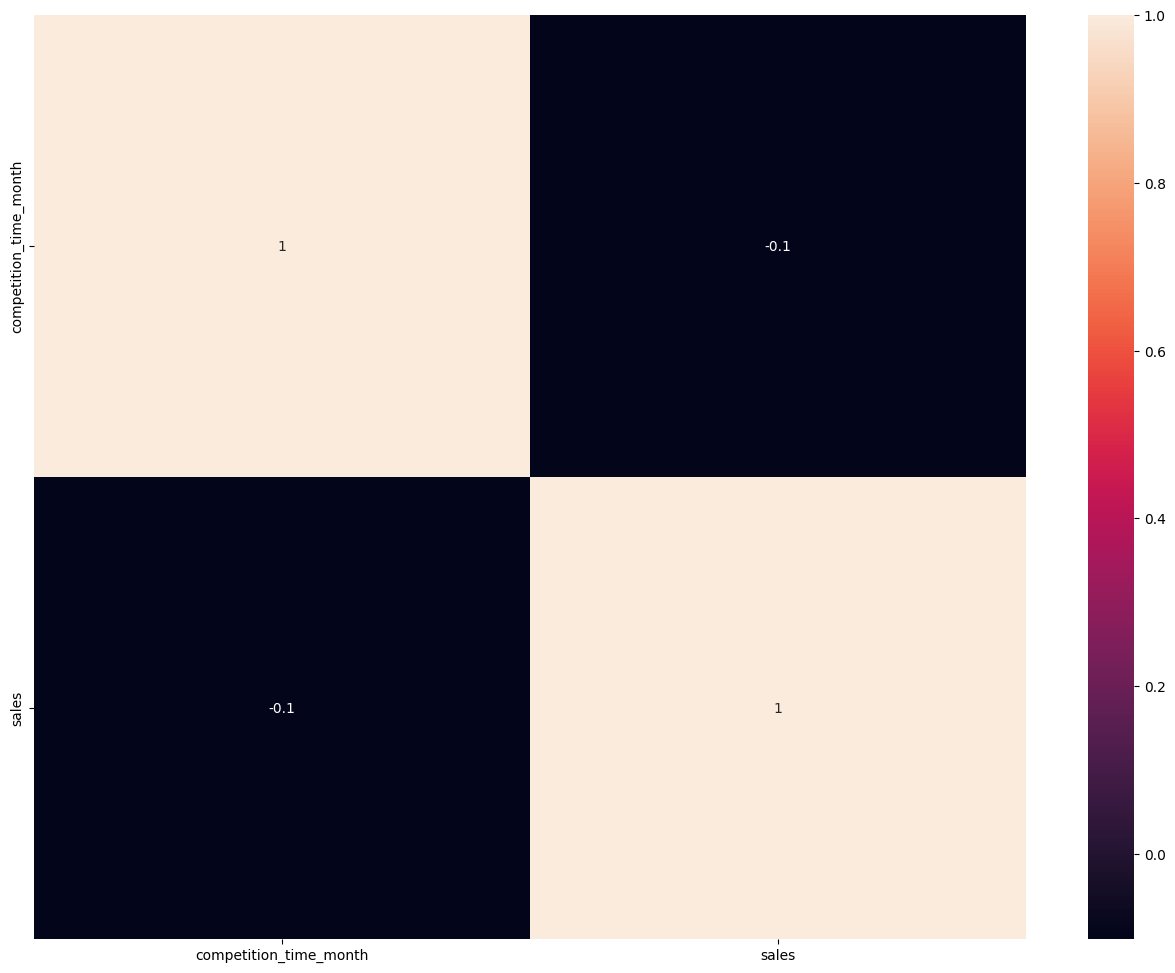

In [42]:
sb.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H13.** Stores with longer active promotions should sell more.

**False.** Analyzing the charts below, it is noticed that when the value of promo_time_week is positive, it indicates that sales were made during the extended promotion period, and if it is negative, sales occurred during the regular promotion period. Therefore, examining the first chart, it is observed that promotions active for a longer period sell regularly, and not only that, over time they tend to decline, which can be confirmed by the trend chart alongside, indicating that the effect of the promotion has a certain period of efficacy.

On the other hand, sales during the regular period tend to grow over time, which may be a result of the marketing department's efforts, where people are informed that the store is in a promotional period resulting in more sales.

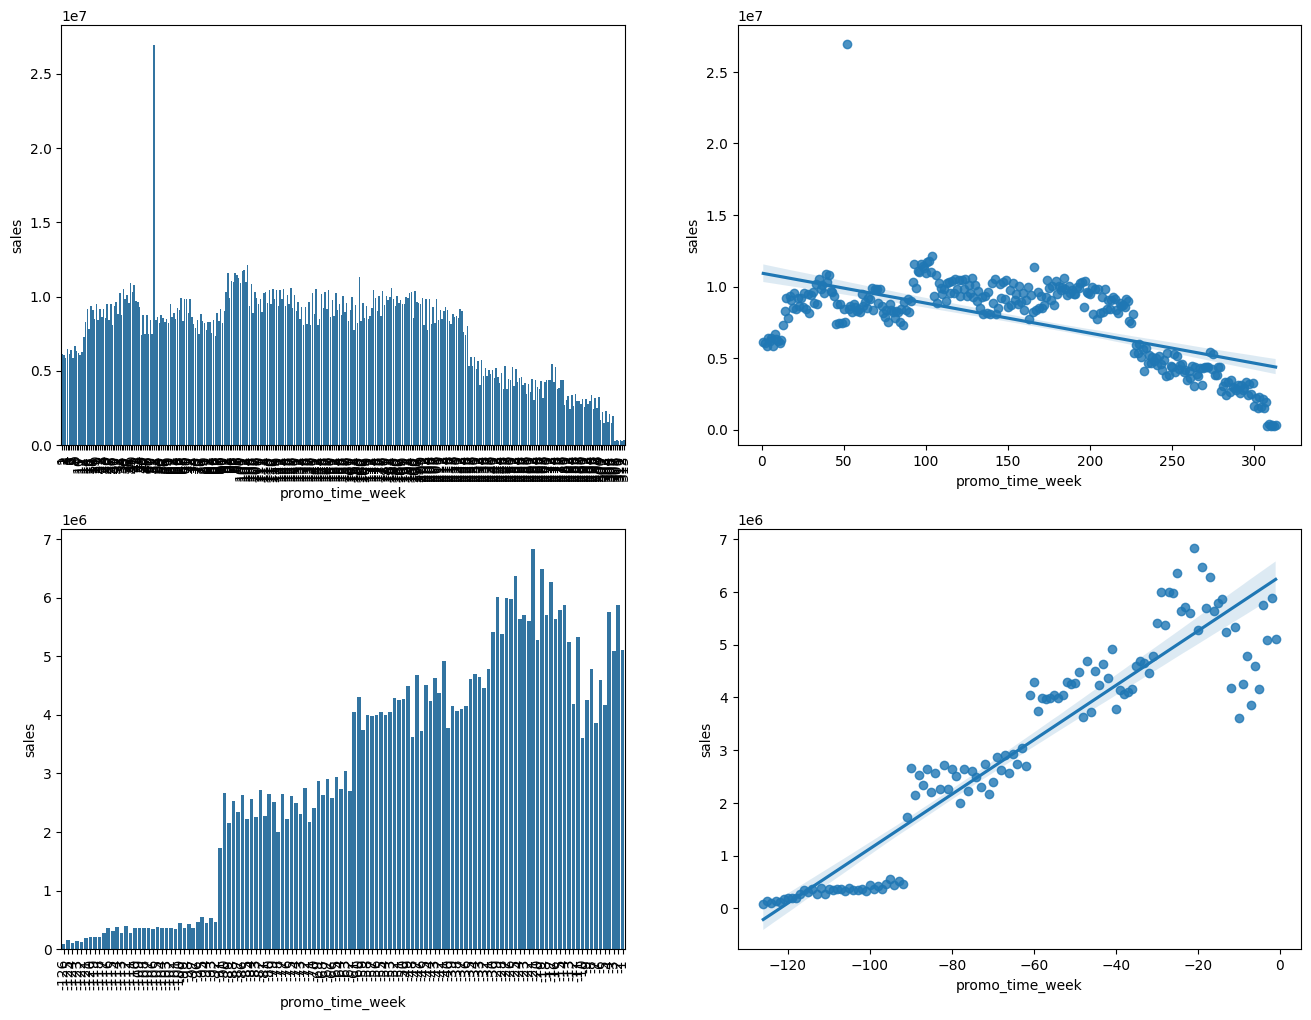

In [43]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week' ).sum().reset_index()

# extended promo
plt.subplot(2, 2, 1)
plt.xticks( rotation=90 )
aux2 = aux1[aux1['promo_time_week'] > 0 ]
sb.barplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot(2, 2, 2)
sb.regplot( x='promo_time_week', y='sales', data=aux2 );

# regular promo
plt.subplot(2, 2, 3)
plt.xticks( rotation=90 )
aux3 = aux1[aux1['promo_time_week'] < 0 ]
sb.barplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot(2, 2, 4)
sb.regplot( x='promo_time_week', y='sales', data=aux3 );

To infer the correlation of the feature with the response variable, a heatmap was used. From this, it is observed that this variable alone has a weak correlation with sales.

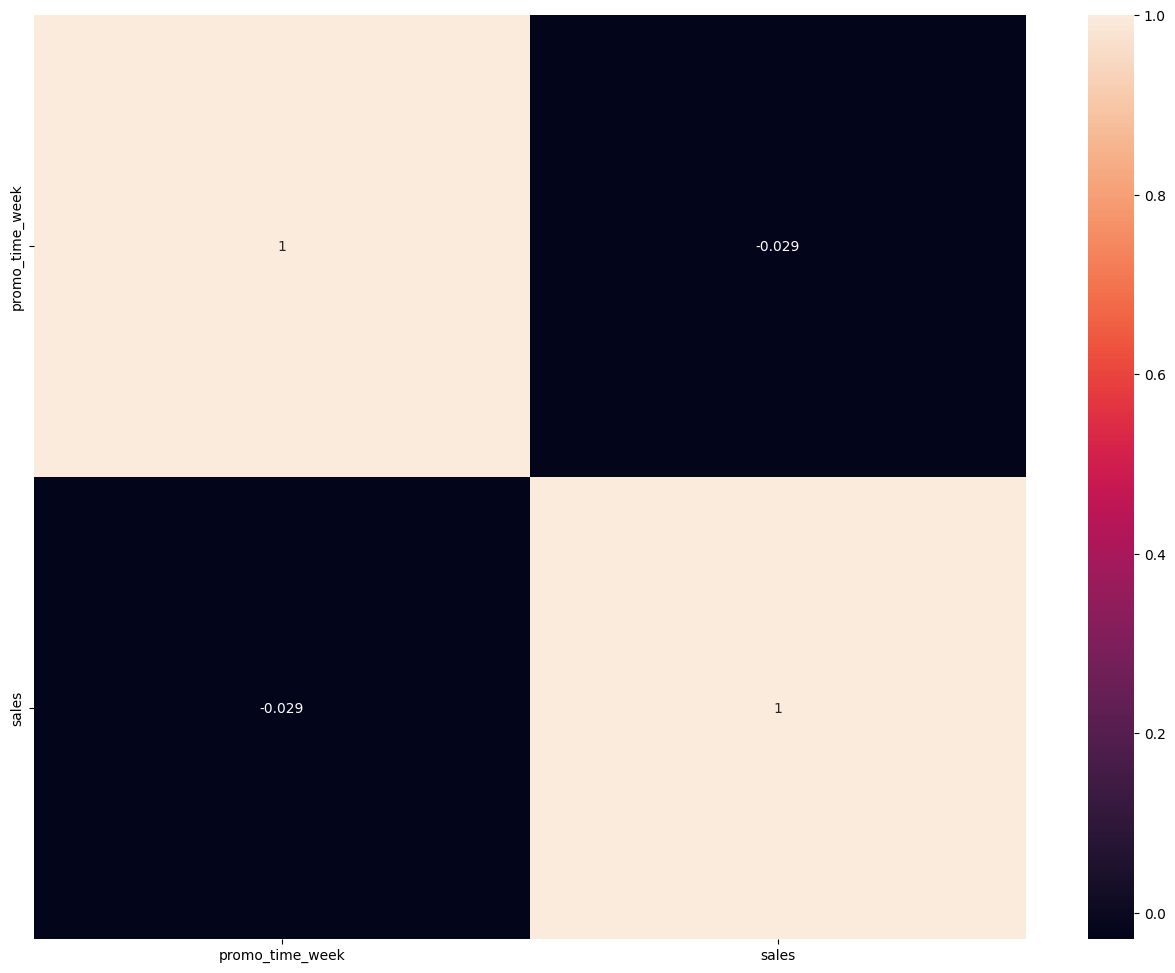

In [44]:
sb.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H14.** Stores with more promotion days should sell more.

*(Strikethrough)* **Reason:** Very similar to Hypothesis 13, requiring the creation of a promo_days variable to be validated, which will be deferred to the next cycle of CRISP-DM.

### **H15.** Stores with more consecutive promotions should sell more.

**False.** Analyzing the table below, it is observed that stores that participated only in the regular promotion **promo** sold more than the stores that participated in the extended promotion **promo2**. An interesting observation is that stores that did not participate in any promotion sold more than those that participated in both promotions simultaneously, which also had a higher sales frequency.

In [45]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2']).sum().reset_index().sort_values( by='sales' )

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


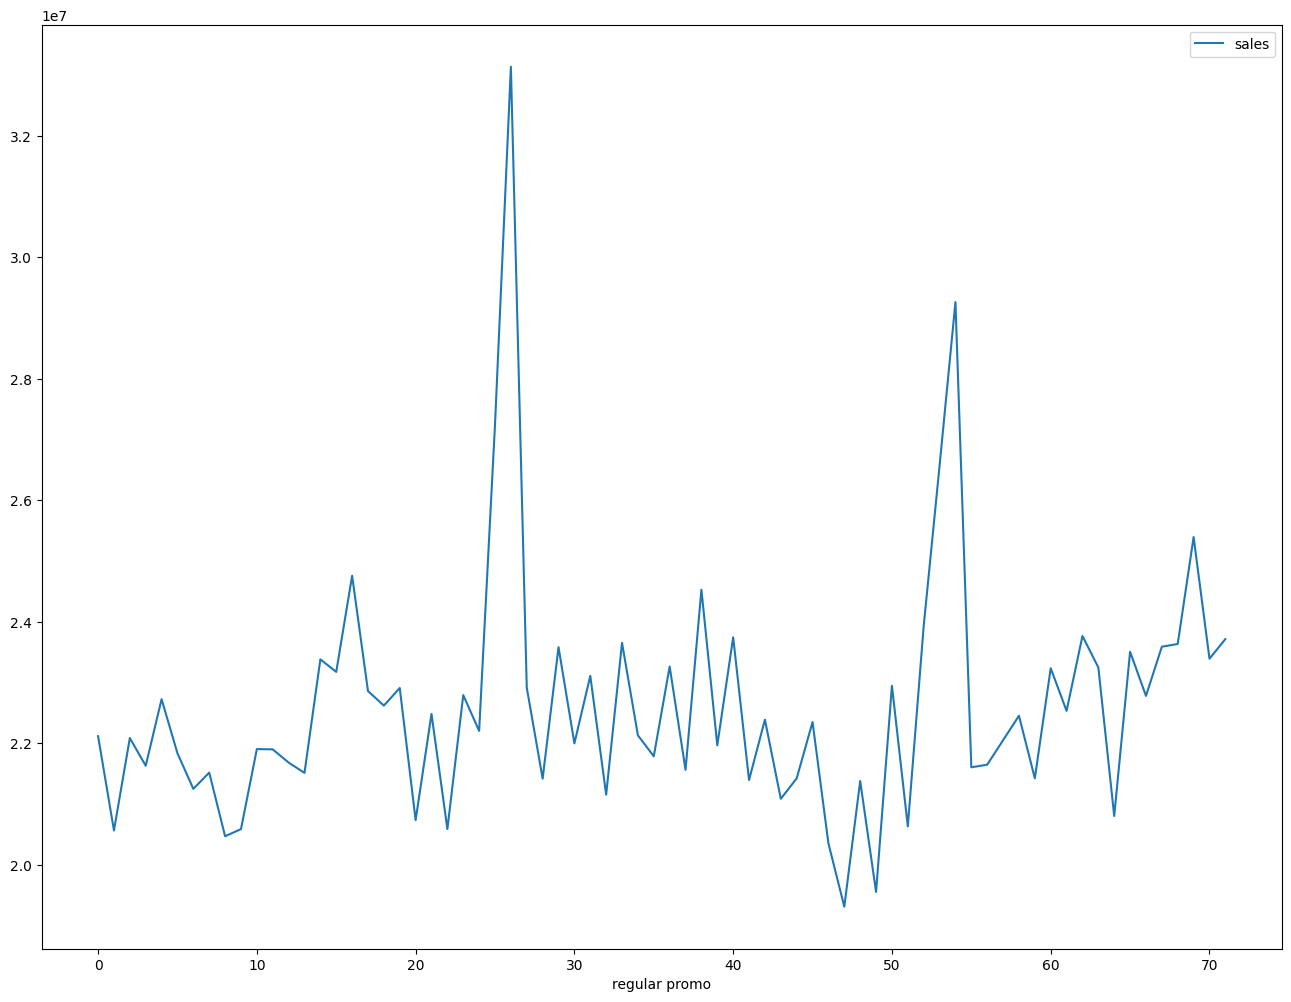

In [46]:
# regular promo
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux1.plot();
plt.xlabel('regular promo');

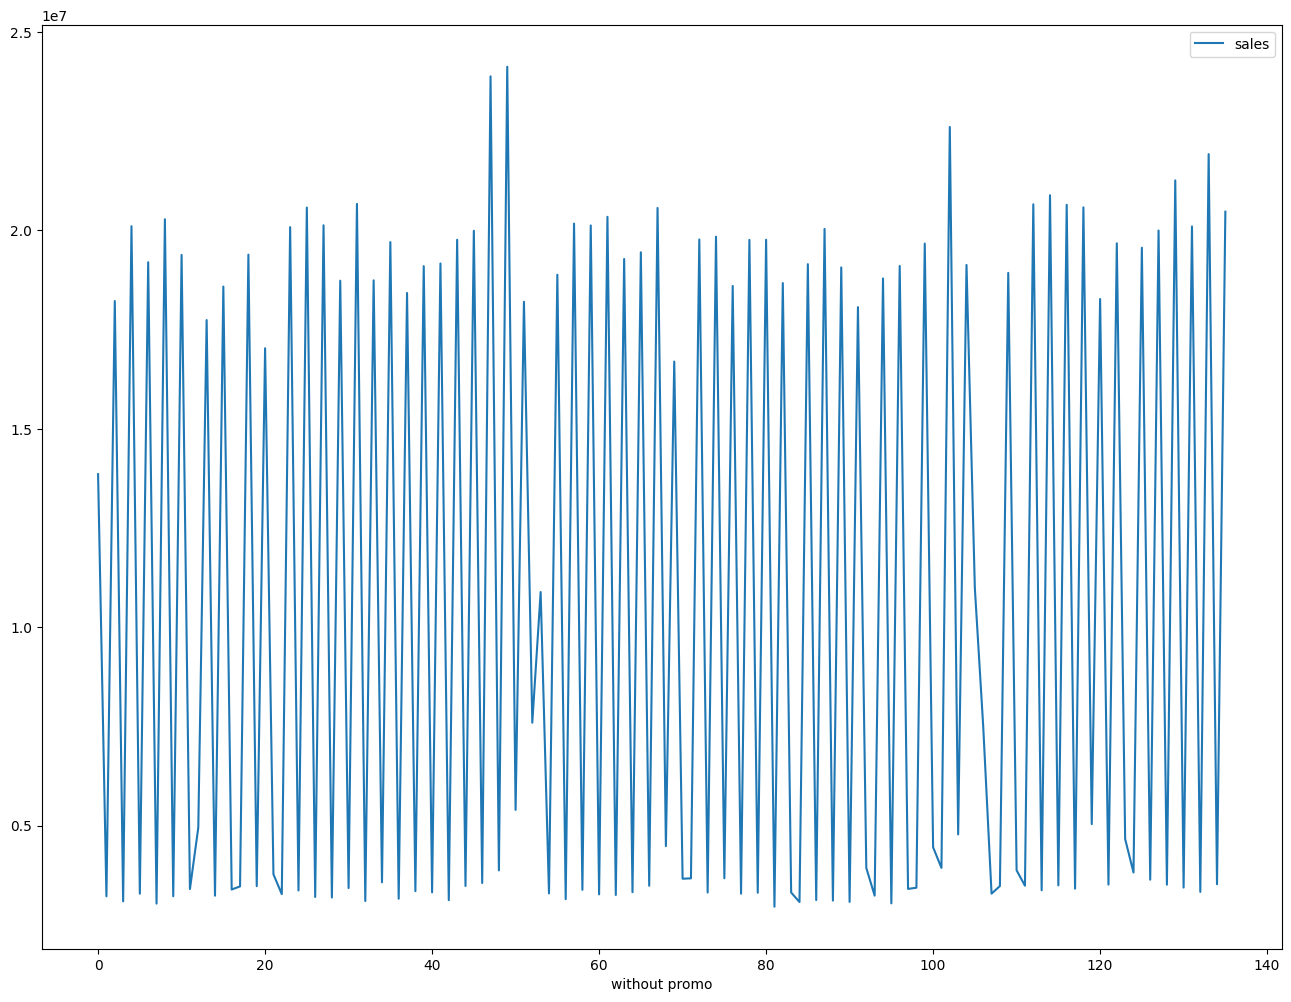

In [47]:
# without promo
aux2 = df4[( df4['promo'] == 0 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot();
plt.xlabel('without promo');

### **H16.** Stores that open during the Christmas holiday should sell more.

**False.** Analyzing the charts below, it is noticeable that stores open during the Christmas holiday sell less. Sales are concentrated on public holidays, not on special dates like Christmas and Easter.

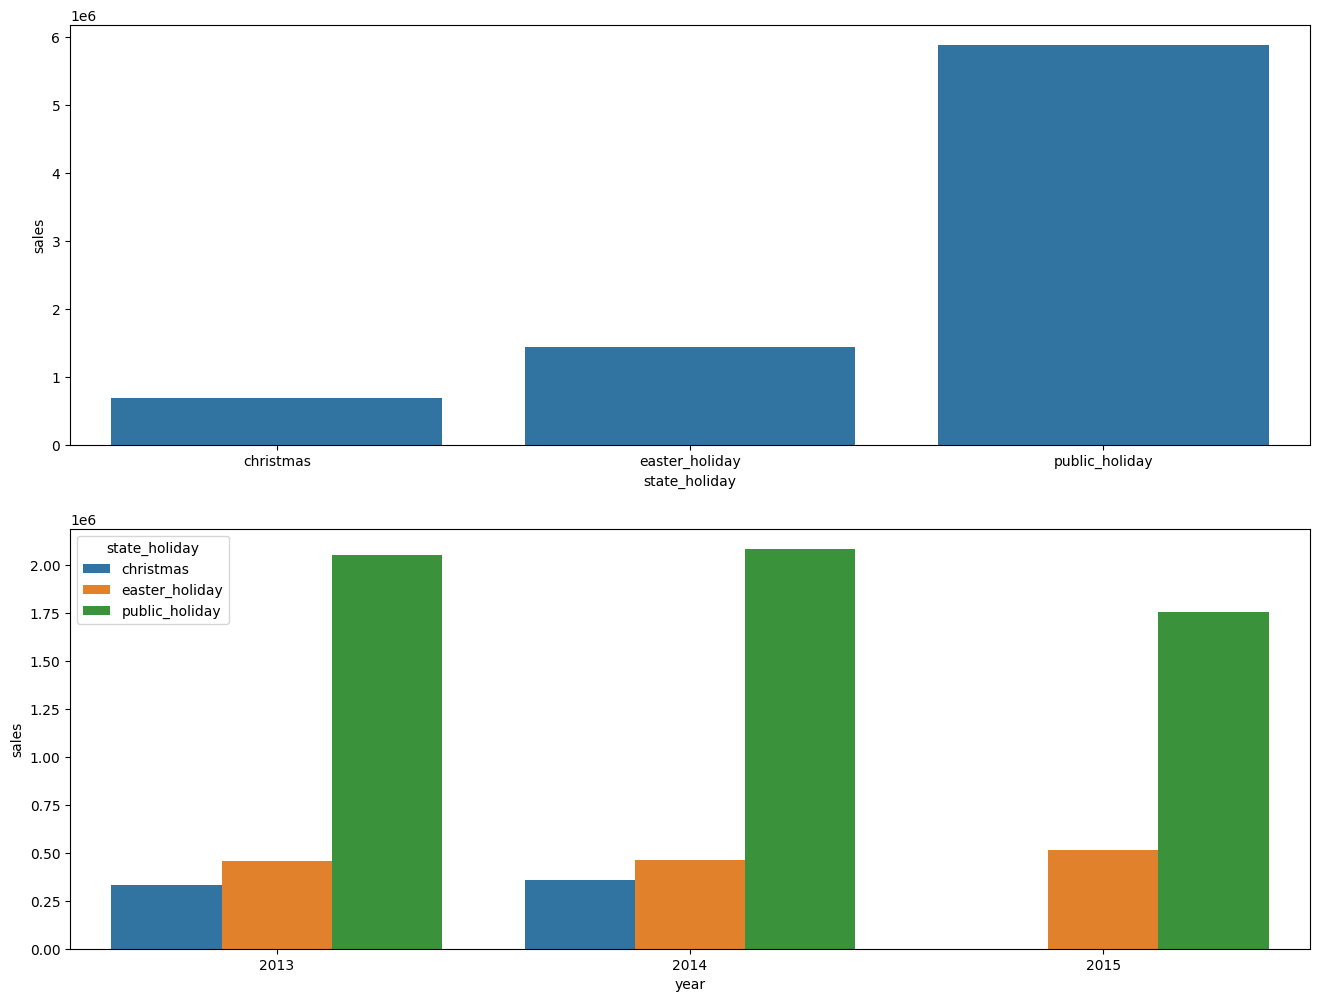

In [48]:
aux1 = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(2, 1, 1)
aux2 = aux1[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sb.barplot( x='state_holiday', y='sales', data=aux2 );

plt.subplot(2, 1, 2)
aux3 = aux1[['year', 'state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sb.barplot( x='year', y='sales', hue='state_holiday',data=aux3 );

### **H17.** Stores should sell less on weekends.

**True.** Analyzing the charts below, it is observed that the volume of sales is higher during the weekdays. Thus, days 6 (Saturday) and 7 (Sunday) are the days when stores sell the least.

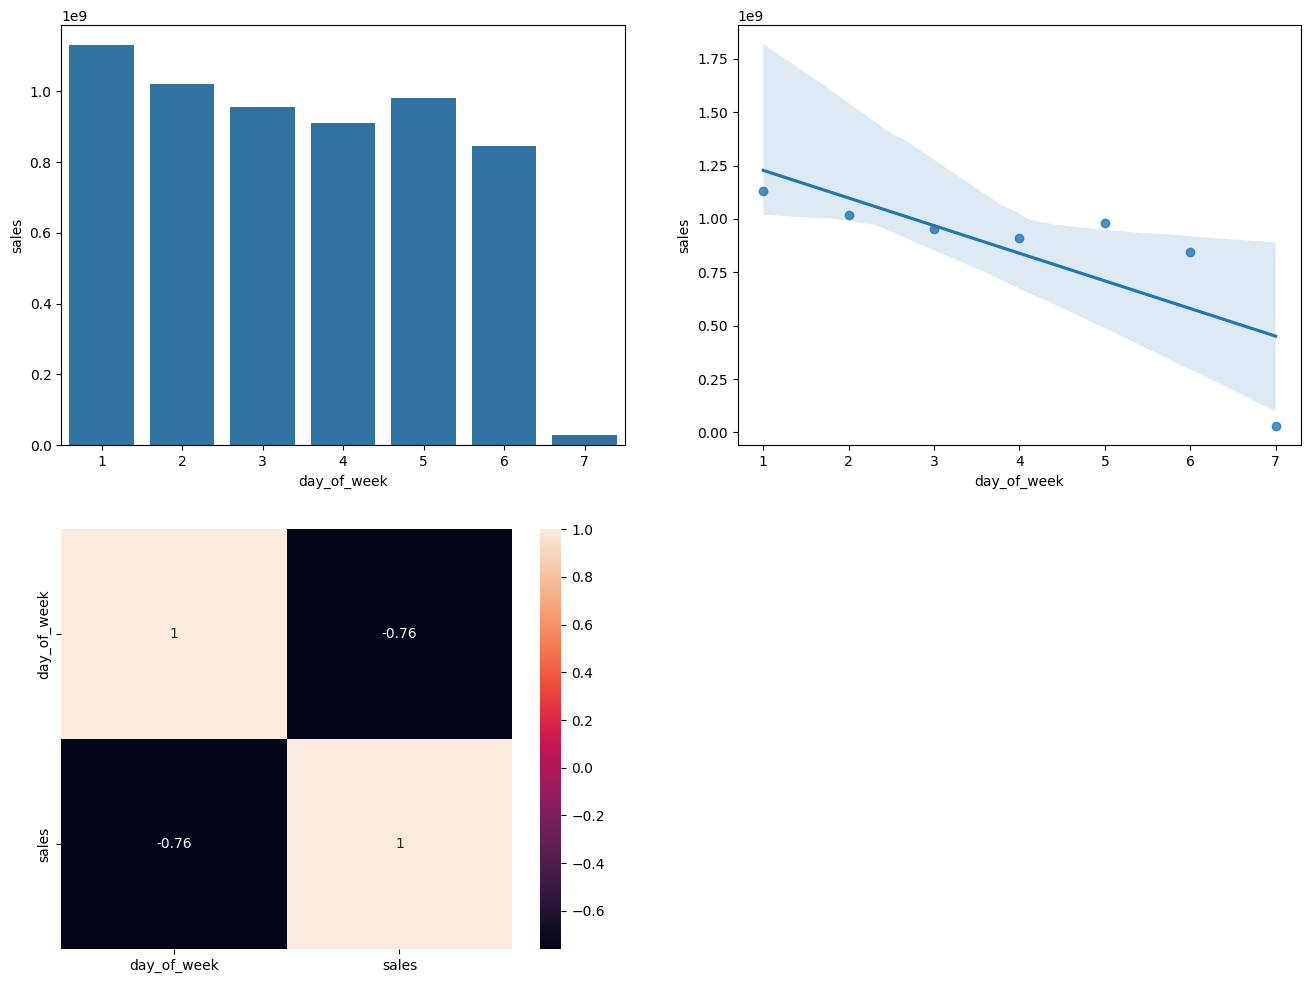

In [50]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 2, 2, 1)
sb.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 2, 2, 2)
sb.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 2, 2, 3)
sb.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H18.** Stores should sell more over the years.

**False.** Analyzing the charts, it is observed that over the years, sales decline rather than increase. Therefore, stores sell less over the years.

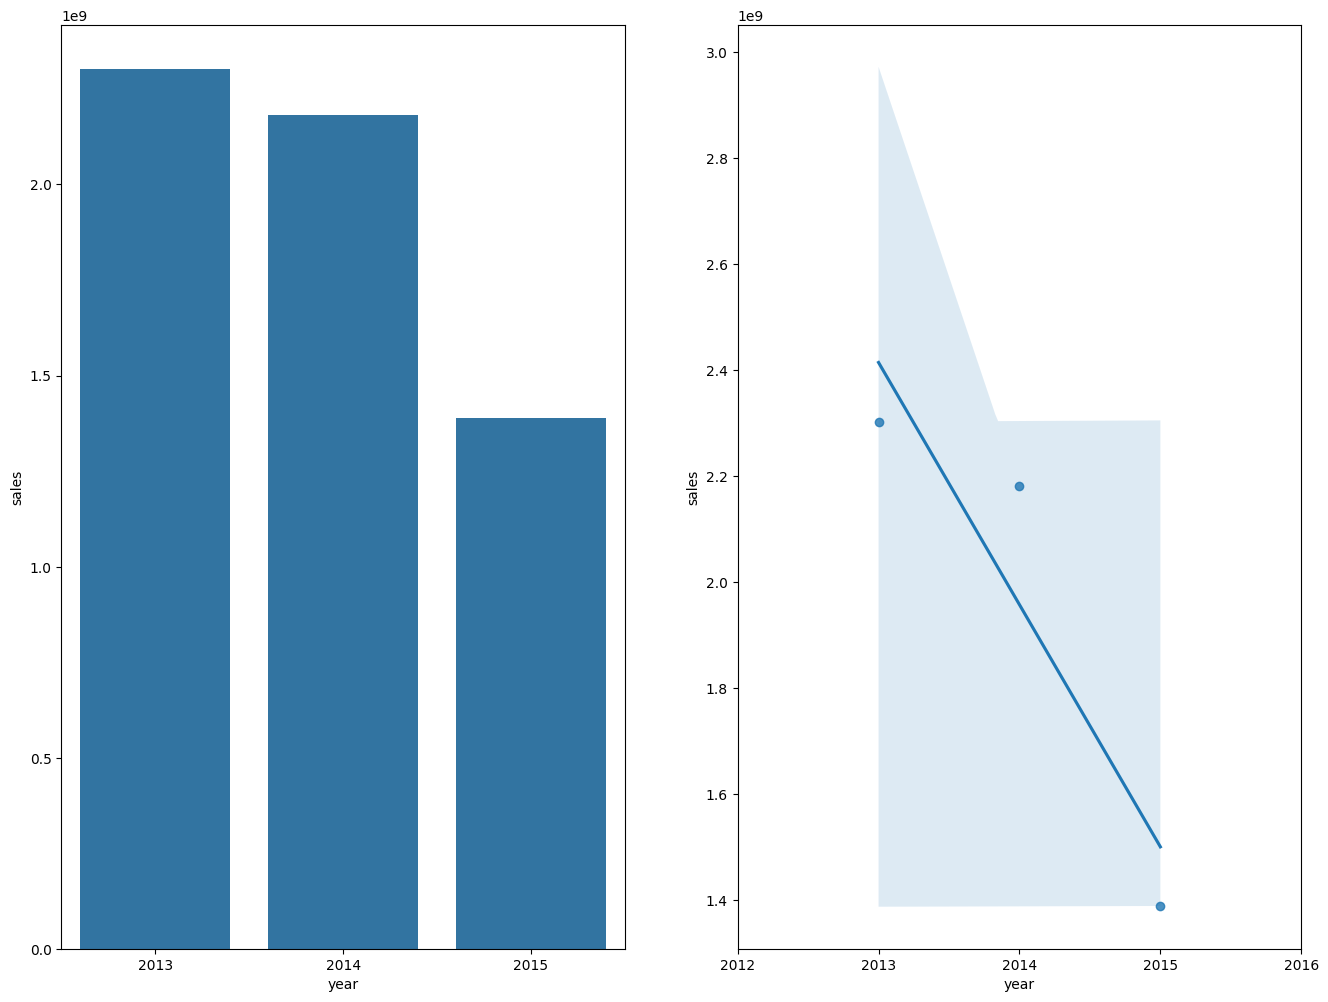

In [51]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 2, 1)
sb.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 2, 2)
sb.regplot( x='year', y='sales', data=aux1 );
plt.xticks([2012, 2013, 2014, 2015, 2016]);

To infer the correlation of the feature with the response variable, a heatmap was used. It is observed that this variable alone has a very strong negative correlation with sales. That is, as the years increase, sales decrease. However, this is due to the fact that this dataset does not have complete data for 2015, which was still ongoing.

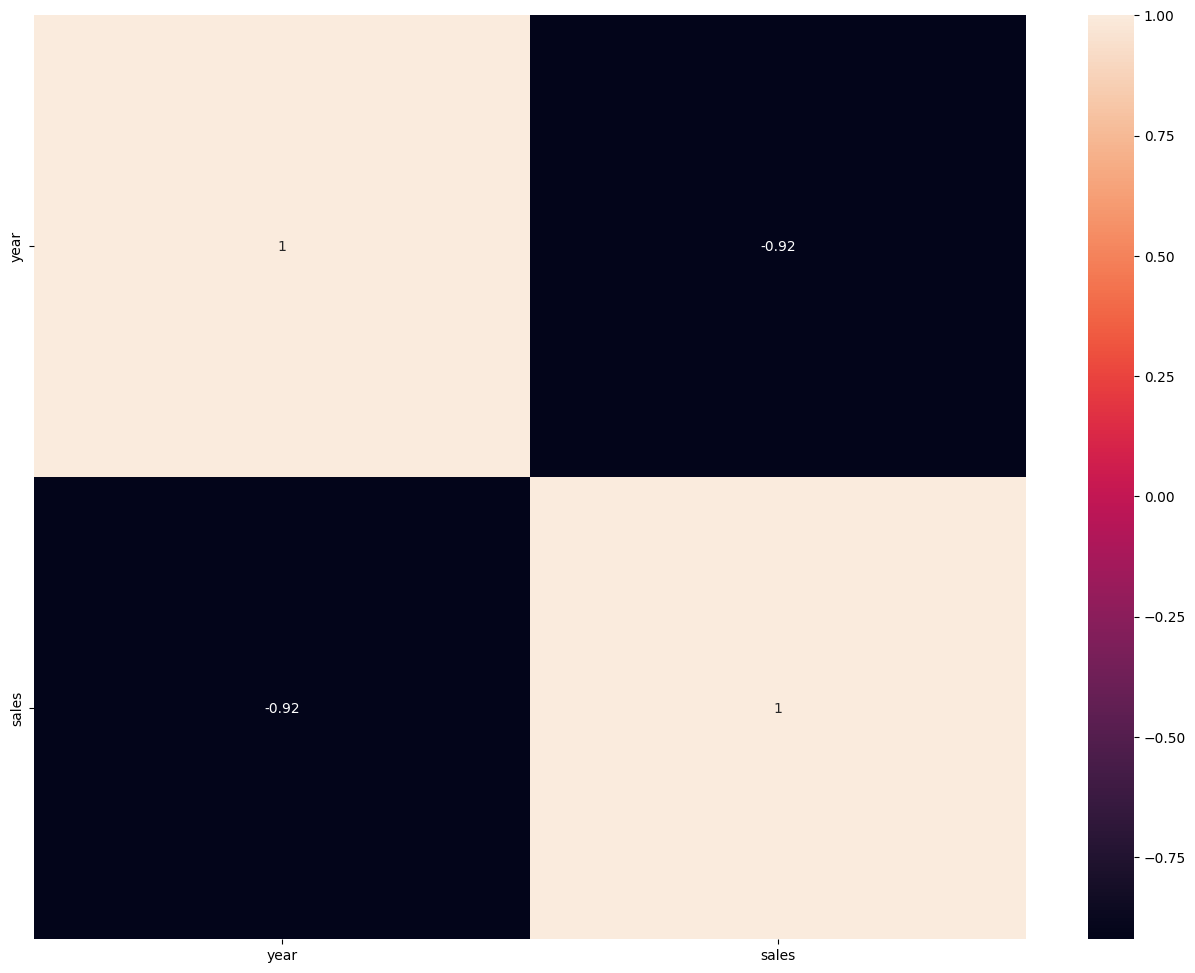

In [52]:
sb.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H19.** Stores should sell more in the second half of the year.

**False.** Analyzing the charts, it is noticeable that in the second half of the year, stores sell less. Thus, in the second half of the year, Rossmann's sales significantly drop, indicating that this company concentrates its main earnings at the beginning of the semester.

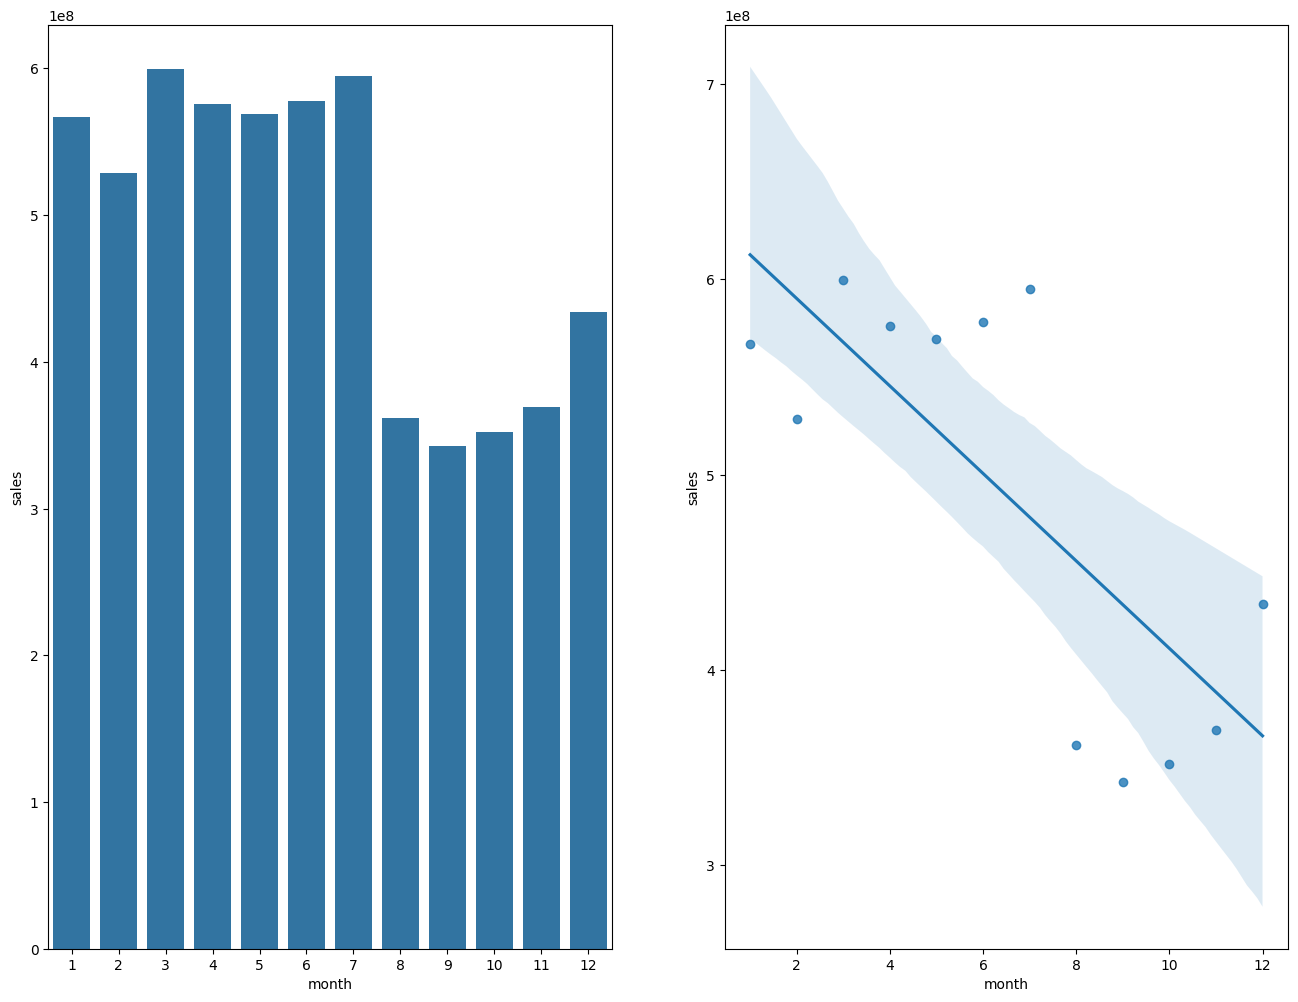

In [53]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 2, 1)
sb.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 2, 2)
sb.regplot( x='month', y='sales', data=aux1 );

To infer the correlation of the feature with the response variable, a heatmap was used. It is observed that this variable alone has a quite strong negative correlation with sales.

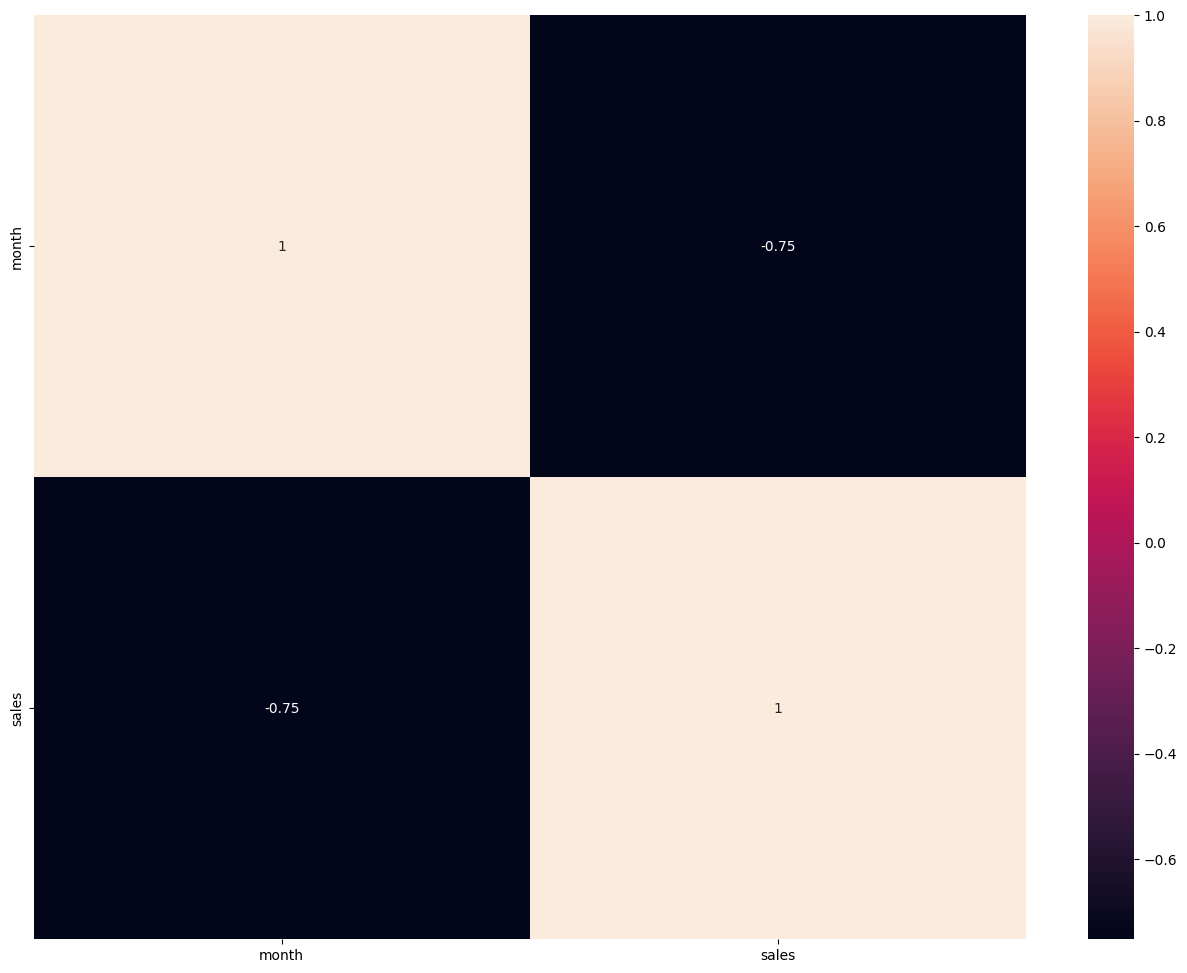

In [54]:
sb.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H20.** Stores should sell more after the 10th of each month.

**True.** Analyzing the charts below, it is noticeable that stores make more sales after the 10th of each month.

To infer the correlation of the feature with the response variable, a heatmap was used. It is observed that this variable alone has a reasonable negative correlation with sales.

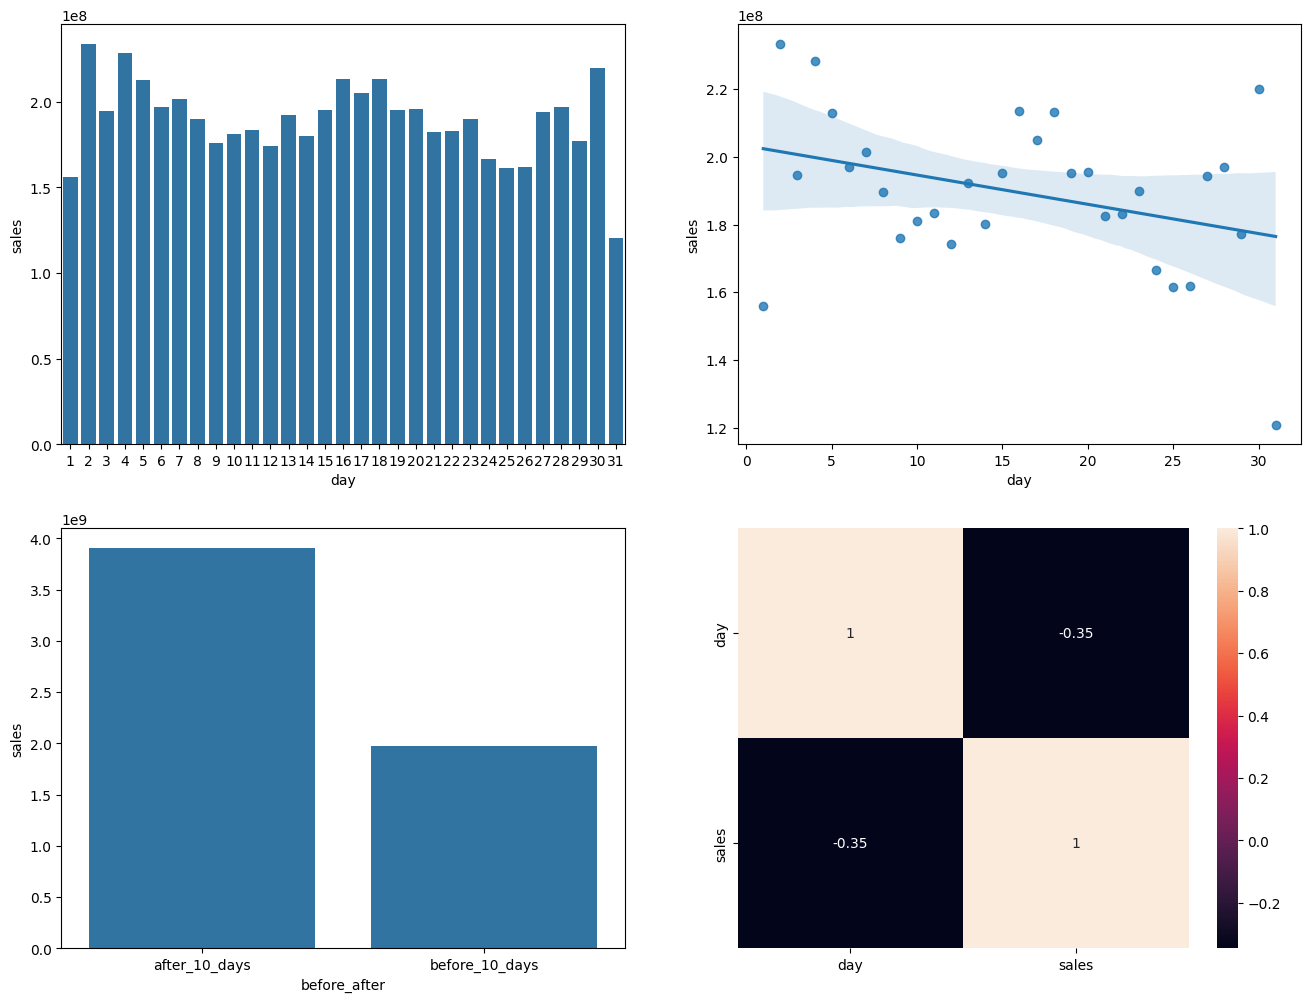

In [55]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1)
sb.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2)
sb.regplot( x='day', y='sales', data=aux1 );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 3)
sb.barplot( x='before_after', y='sales', data=aux2 );

plt.subplot( 2, 2, 4)
sb.heatmap( aux1[['day','sales']].corr( method='pearson' ), annot=True );

### **H21.** Stores should sell less during school holidays.

**True.** Analyzing the charts below, it is noticeable that stores sell less during school holidays, except in the month of August, where sales exceeded those of the normal period. It is also observable that there was a sudden increase in sales in the months of July and August. A theory behind this discovery might be that during these months, students are on school vacation, spending much more time outside of school, consequently creating more opportunities for shopping.

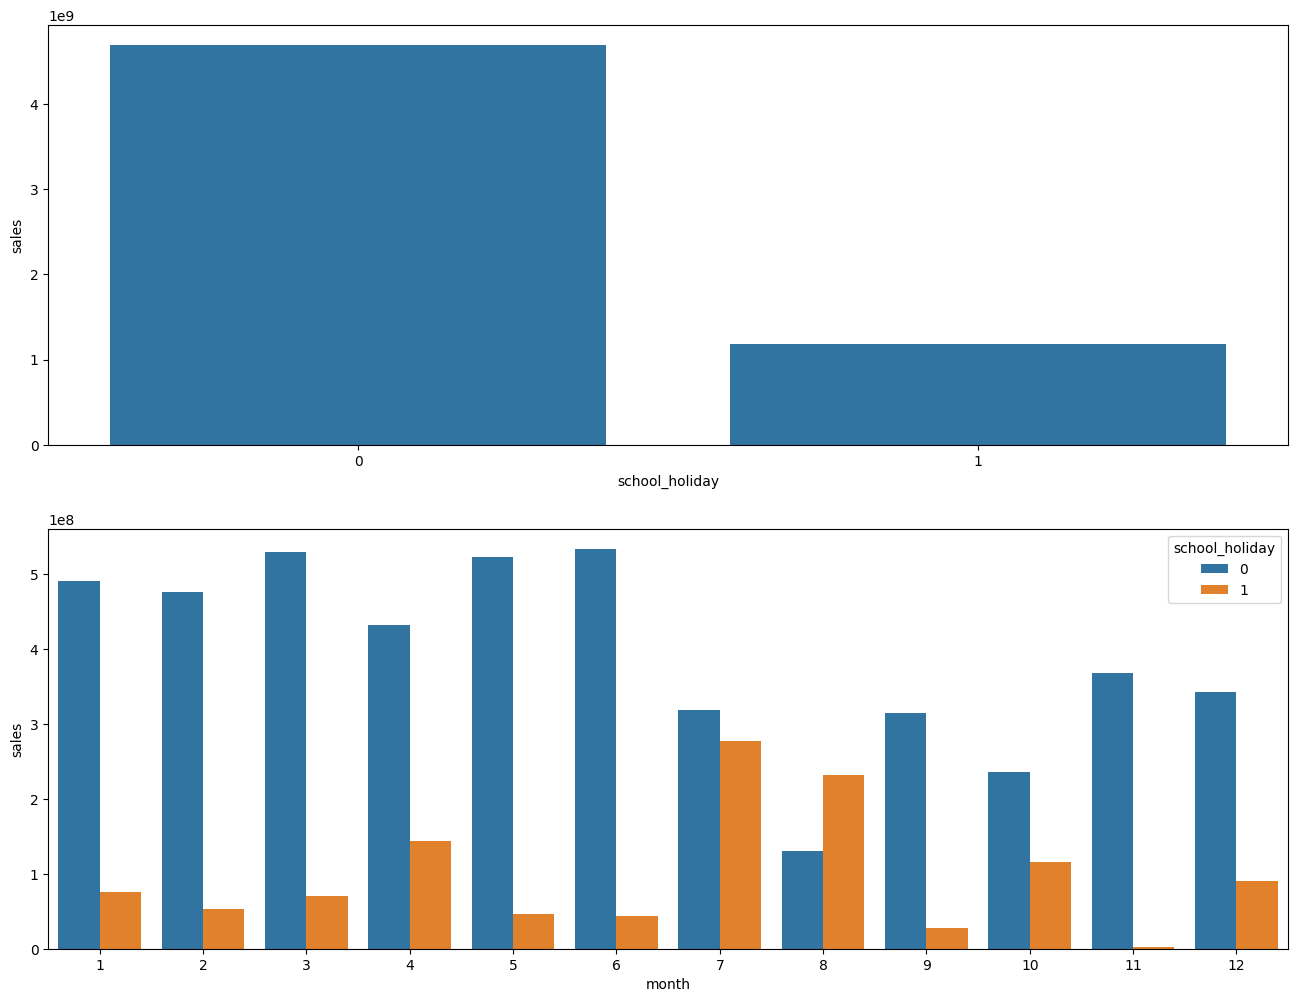

In [56]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2, 1, 1)
sb.barplot( x='school_holiday', y='sales', data=aux1 );

plt.subplot(2, 1, 2)
aux2 = df4[['month','school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
sb.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

### 4.2.1. Hypothesis Resume

In [57]:
from tabulate import tabulate

# Define the table data
tab = [
    ['Hypothesis', 'Conclusion', 'Relevance'],
    ['H5', 'False', 'Low'],
    ['H6', 'False', 'Medium'],
    ['H7', 'False', 'Medium'],
    ['H13', 'False', 'Low'],
    ['H14', '-', '-'],
    ['H15', 'False', 'Low'],
    ['H16', 'False', 'Medium'],
    ['H17', 'True', 'High'],
    ['H18', 'False', 'High'],
    ['H19', 'False', 'High'],
    ['H20', 'True', 'High'],
    ['H21', 'True', 'Low'],
]

# Print the table with headers from the first row
print(tabulate(tab, headers='firstrow'))


Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H5            False         Low
H6            False         Medium
H7            False         Medium
H13           False         Low
H14           -             -
H15           False         Low
H16           False         Medium
H17           True          High
H18           False         High
H19           False         High
H20           True          High
H21           True          Low


## 4.3. Multivariate Analysis

### 4.3.1. Numercial Attributes

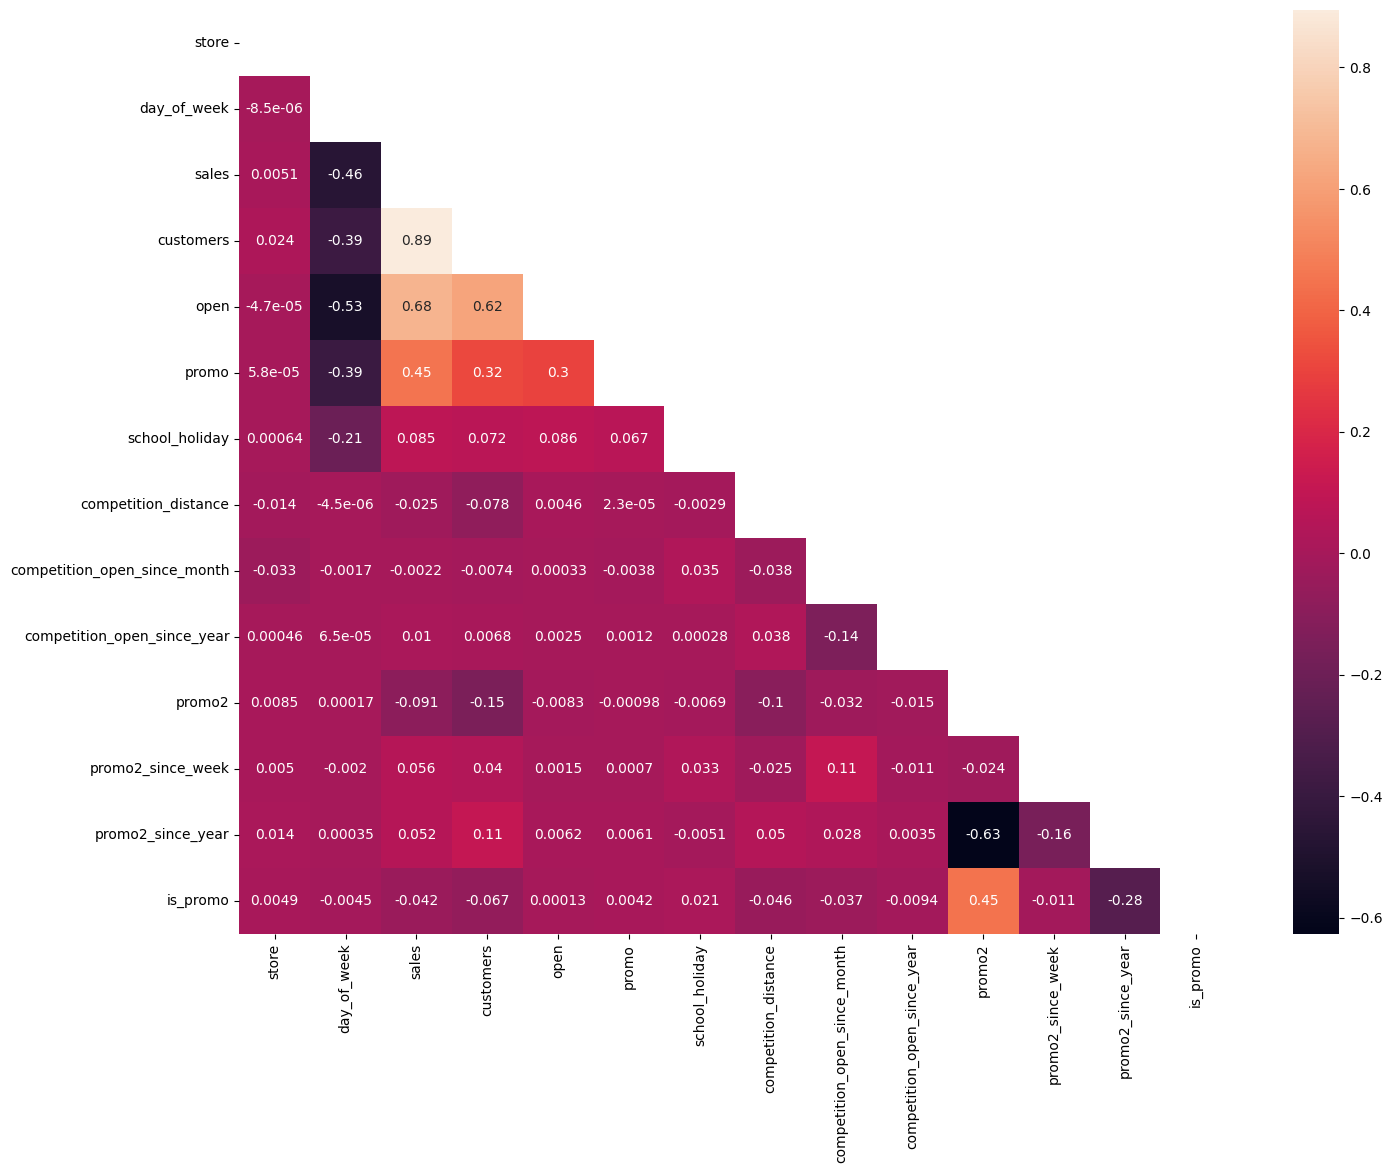

In [58]:
correlation = num_attributes.corr( method='pearson' )

# generate a mask for the upper triangle
mask = np.triu( np.ones_like(correlation, dtype=bool) )

sb.heatmap( correlation, annot=True, mask=mask );

### 4.3.2. Categorical Attributes

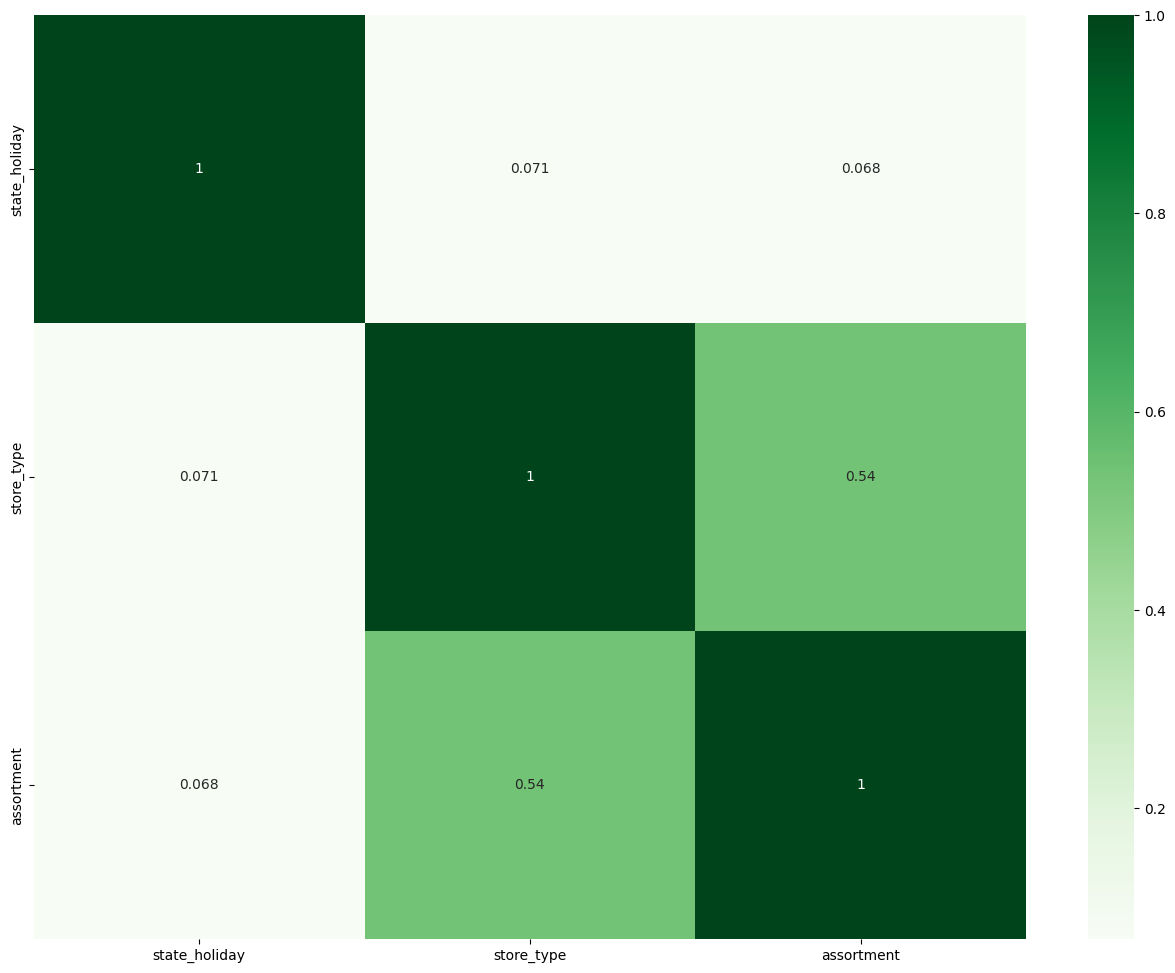

In [59]:
# only categorical data
new_catg = df4.select_dtypes( include='object' )

# calculate cramer V
catg1 = cramer_v(new_catg['state_holiday'], new_catg['state_holiday'])
catg2 = cramer_v(new_catg['state_holiday'], new_catg['store_type'])
catg3 = cramer_v(new_catg['state_holiday'], new_catg['assortment'])

catg4 = cramer_v(new_catg['store_type'], new_catg['state_holiday'])
catg5 = cramer_v(new_catg['store_type'], new_catg['store_type'])
catg6 = cramer_v(new_catg['store_type'], new_catg['assortment'])

catg7 = cramer_v(new_catg['assortment'], new_catg['state_holiday'])
catg8 = cramer_v(new_catg['assortment'], new_catg['store_type'])
catg9 = cramer_v(new_catg['assortment'], new_catg['assortment'])

# cramer's V resume
catg_resume = pd.DataFrame( {
                                'state_holiday': [catg1, catg2, catg3],
                                'store_type': [catg4, catg5, catg6],
                                'assortment': [catg7, catg8, catg9],              
                            })

catg_resume = catg_resume.set_index( catg_resume.columns )
sb.heatmap( catg_resume, annot=True, cmap='Greens' );

# 5.0. DATA PREPARATION

In [67]:
df5 = df4.copy()

### 5.1. Normalization
Analyzing the charts of the numerical features in section 4.1.2. Numerical Variable, it was observed that the data we are working with do not have a normal distribution. Therefore, normalization of these data will not be applied. This step would be used if any feature exhibited a pattern of normal distribution, which is not the case.

### 5.2. Rescaling
To identify which transformation method to use, a boxplot of the variables below was plotted to determine the best method of transformation to use. Analyzing the charts below, it was noted that for the features `competition_distance` and `competition_time_month`, the most suitable method will be the Robust Scaler, due to its high number of outliers. For the features `year` and `promo_time_week`, the transformation method will be the Min Max Scaler, as they do not have as many outliers.

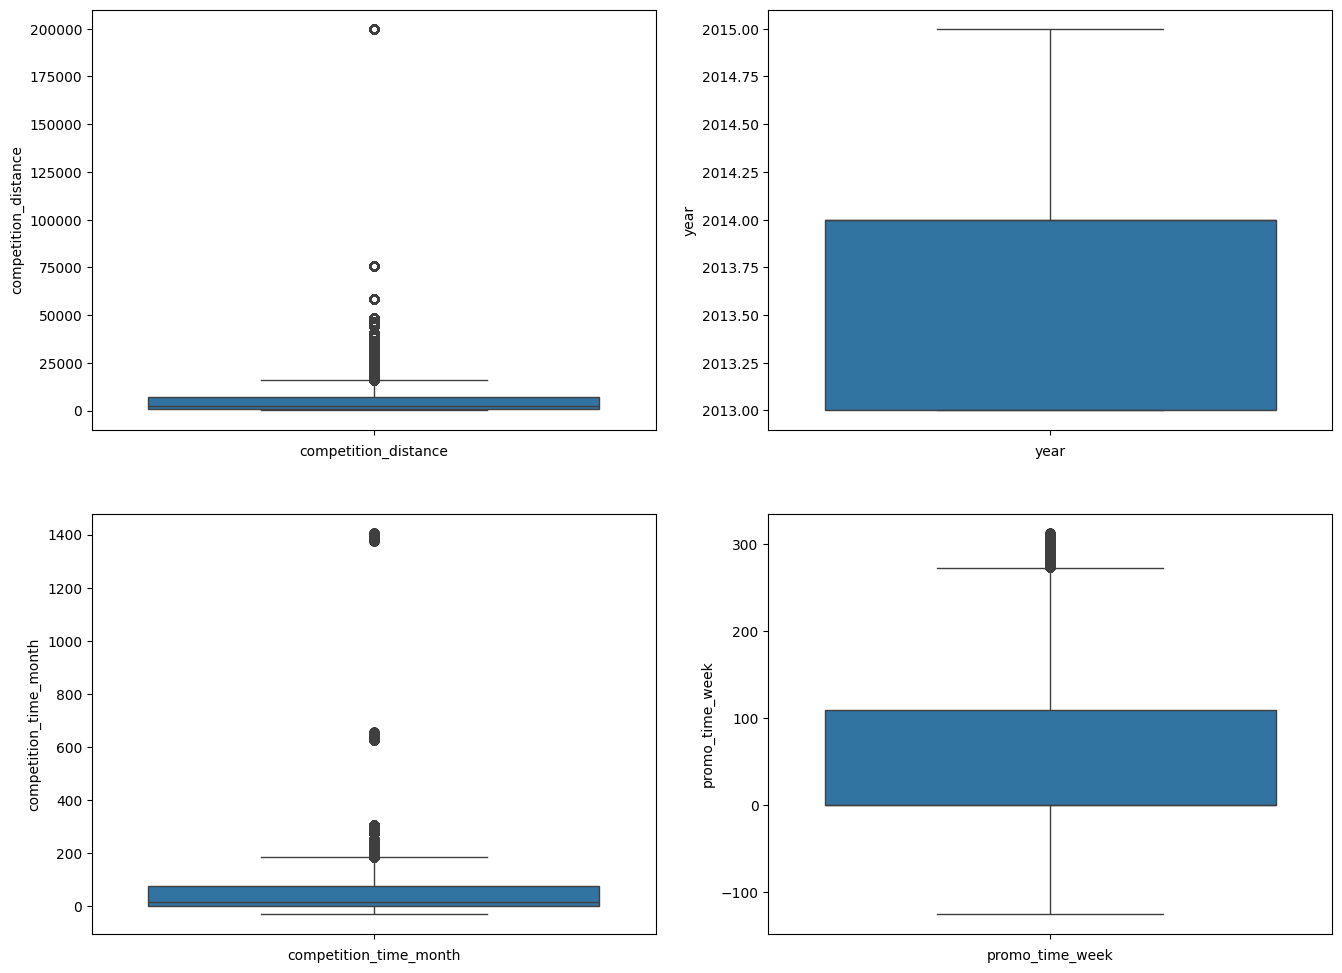

In [68]:
plt.subplot(2, 2, 1)
sb.boxplot( data=df5['competition_distance'] );
plt.xlabel('competition_distance');

plt.subplot(2, 2, 2)
sb.boxplot( data=df5['year'] );
plt.xlabel('year');

plt.subplot(2, 2, 3)
sb.boxplot( data=df5['competition_time_month'] );
plt.xlabel('competition_time_month');

plt.subplot(2, 2, 4)
sb.boxplot( data=df5['promo_time_week'] );
plt.xlabel('promo_time_week');

In [69]:
# applying transformations
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( 'encoding_competition_distance_scaler.pkl', 'wb' ) )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( 'encoding_year_scaler.pkl', 'wb' ) )

# competition_time_month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( 'encoding_competition_time_month_scaler.pkl', 'wb' ) )

# promo_time_week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( mms, open( 'encoding_promo_time_week_scaler.pkl', 'wb' ) )

## 5.3. Transformation

### 5.3.1. Encoding

In this phase, I will use some commonly employed methods for encoding categorical variables. Since we are in the first cycle of CRISP, I will use encoding according to the *feeling of the variable*, that is, applying transformations that make sense for each feature. It’s important to note that nothing prevents using the same type of encoding for all variables, which can be reviewed in the second cycle.

In [70]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'store_type_scaler.pkl', 'wb' ) )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. Response Variable Transformation

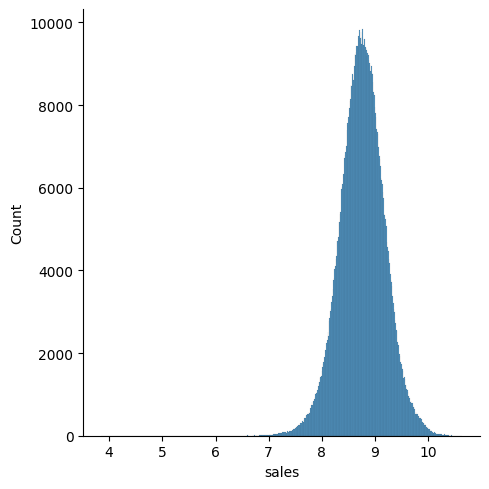

In [71]:
df5['sales'] = np.log1p( df5['sales'] )
sb.displot( df5['sales'] );

### 5.3.3. Nature Transformation

This step is very important for maintaining the cyclical nature of time periods throughout the years, such as day, month, day of the week, week of the year, etc. Although this step results in adding more columns to the dataset, consequently increasing its dimensionality, it leads to a gain during the training of the machine learning algorithm, which will be able to understand this phenomenon with much greater clarity and precision.

In [72]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi /7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi /7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi /12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi /12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi /30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi /30 ) ) )

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi /52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi /52 ) ) )

# 6.0. FEATURE SELECTION

In [73]:
df6 = df5.copy()

## 6.1. Split Data Frame Into Training and Test

In [74]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1 )

Identifying the training and testing dates. The last 6 weeks will be the test data, and the training data will consist of the entire dataset up to the cutoff date discovered by the code below.

In [75]:
df6[['date', 'store']].groupby( 'store' ).max().reset_index()['date'][0] - datetime.timedelta( days=6*7 )

Timestamp('2015-06-19 00:00:00')

In [76]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training min date: {}'.format( X_train['date'].min() ) )
print('Training max date: {}'.format( X_train['date'].max() ) )

print('\nTest min date: {}'.format( X_test['date'].min() ) )
print('Test max date: {}'.format( X_test['date'].max() ) )

Training min date: 2013-01-01 00:00:00
Training max date: 2015-06-18 00:00:00

Test min date: 2015-06-19 00:00:00
Test max date: 2015-07-31 00:00:00


array([[1, 1, 0, ..., -0.8090169943749476, 0.1205366802553235,
        -0.992708874098054],
       [2, 1, 0, ..., -0.8090169943749476, 0.1205366802553235,
        -0.992708874098054],
       [3, 1, 0, ..., -0.8090169943749476, 0.1205366802553235,
        -0.992708874098054],
       ...,
       [769, 0, 1, ..., 0.9781476007338057, 0.12053668025532305,
        0.992708874098054],
       [948, 0, 1, ..., 0.9781476007338057, 0.12053668025532305,
        0.992708874098054],
       [1097, 0, 1, ..., 0.9781476007338057, 0.12053668025532305,
        0.992708874098054]], dtype=object)

## 6.2. Boruta as Feature Selector

The snippets are commented out because their main purpose is to identify which features are most relevant for the Machine Learning model. Since Boruta is an algorithm that requires a long processing time, a section **6.3. Manual Features Selection** was created to store all the variables that this algorithm selected as being important for the model.

In [83]:
## training and test dataset for Boruta
X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
y_train_n = y_train.values.ravel()

X_train_n = X_train_n.astype(int)
y_train_n = y_train_n.astype(int)

rf = RandomForestRegressor( n_jobs=-1 )

## define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=9 ).fit( X_train_n, y_train_n )

### 6.2.1 Best Feature from Boruta

In [ ]:
cols_selected = boruta.support_.tolist()

## best features
X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
cols_selected_boruta = X_train_fs.ilocs[:, cols_selected].columns.to_list()

## columns not selected by boruta
cols_not_selected_boruta = list ( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 6.3. Manual Features Selection

In [85]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. MACHINE LEARNING MODELLING

In [86]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series data preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

In [87]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [88]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

In [89]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model

In [90]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression Regularized - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Regularized - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Linear Regression Regularized Model - Cross Validation

In [91]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## Average and Linear Models Resume

Analisando a performance dos modelos de comportamento linear, percebeu-se que estes obtiveram um desempenho pior do que um modelo simples de média (**Average Model**). Analisando este fato, nos da a confirmação de que o fenômeno que o modelo está tentando aprender possui um comportamento não linear. Portanto, no próximo passo será utilizado algoritmos não lineares para que o modelo consiga aprender e melhorar o seu desempenho.

## 7.4. Random Forest Regressor

In [92]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=9 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,686.331626,0.101003,1023.791053


### 7.4.1 Random Forest Regressor - Cross Validation

In [93]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.85 +/- 215.37,0.12 +/- 0.02,1256.11 +/- 316.41


## 7.5. XGBoost Regressor

In [94]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror', n_estimators=100, eta=0.01, 
                             max_depth=10, subsample=0.7, colsample_bytee=0.9 ).fit( x_train, y_train )

yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

/usr/local/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:36:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1695.785983,0.251783,2478.398036


### 7.5.1 XGBoost Regressor - Cross Validation

In [95]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5


/usr/local/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:36:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)



KFold Number: 4


/usr/local/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:36:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)



KFold Number: 3


/usr/local/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:36:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)



KFold Number: 2


/usr/local/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:36:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)



KFold Number: 1


/usr/local/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:36:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1860.64 +/- 291.01,0.25 +/- 0.01,2685.39 +/- 429.0


## 7.6. Compare Models Performance

### 7.6.1 Single Performance

In [96]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,686.331626,0.101003,1023.791053
0,Average Model,1354.800353,0.455051,1835.135542
0,XGBoost Regressor,1695.785983,0.251783,2478.398036
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression Regularized - Lasso,1891.704881,0.289106,2744.451737


### 7.6.2 Real Performance - Cross Validation

In [97]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv.sort_values( 'RMSE CV' )

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.85 +/- 215.37,0.12 +/- 0.02,1256.11 +/- 316.41
0,XGBoost Regressor,1860.64 +/- 291.01,0.25 +/- 0.01,2685.39 +/- 429.0
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


Analyzing the performance of non-linear algorithms, it was observed that the two algorithms that showed the best results were **Random Forest Regressor** and **XGBoost Regressor**. Both presented very similar RMSE (Root Mean Squared Error) values, which were significantly lower than those of the linear algorithms. Thus, as a data scientist, it is my responsibility to choose which model will be used in production. Considering the training time of the **Random Forest Regressor** and the potential financial cost this algorithm could entail for implementation—given that the difference between it and the **XGBoost Regressor** is not so substantial compared to other models—I have decided to choose **XGBoost** as the ideal algorithm to deploy the model in production and to make the necessary parameter adjustments to enhance its performance.

# 8.0. HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [98]:
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytee': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
}

MAX_EVAL = 5

In [ ]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
  # choose values for parameters randomly
  hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
 print( hp )

  # model
  model_xgb = xgb.XGBRegressor( objective='reg:squarederror', n_estimators=hp['n_estimators'], eta=hp['eta'], 
                              max_depth=hp['max_depth'], subsample=hp['subsample'], colsample_bytee=hp['colsample_bytee'], min_child_weight=hp['min_child_weight'] ).fit( x_train, y_train )

  # prediction
  yhat_xgb = model_xgb.predict( x_test )

  # performance
  result = cross_validation( x_training, 2, 'XGBoost Regressor', model_xgb )
  final_result = pd.concat( [final_result, result] )

final_result.sort_values( 'RMSE CV' )

## 8.2. Final Model

In [103]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytee': 0.7,
    'min_child_weight': 3 
}

In [104]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror', n_estimators=param_tuned['n_estimators'], eta=param_tuned['eta'], max_depth=param_tuned['max_depth'], 
                             subsample=param_tuned['subsample'], colsample_bytee=param_tuned['colsample_bytee'], min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

/usr/local/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:37:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,769.902806,0.115168,1115.278071


In [ ]:
# saving trained model
#pickle.dump(  model_xgb_tuned, open( 'app/model/rossmann_xgb_model.pkl', 'wb' ) )

# 9.0. ERROR INTERPRETATION AND TRANSLATION

In [105]:
df9 = X_test[ cols_selected_boruta_full ]

# rescaling
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

/tmp/ipykernel_601/1333310647.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1( df9['sales'] )
/tmp/ipykernel_601/1333310647.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1( yhat_xgb_tuned )


## 9.1. Business Performance

In [137]:
'''# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'} )
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'} )

# merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'sales', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]'''

In [142]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Assuming df9 is already defined and includes 'store', 'sales', and 'predictions' columns

# Sum of predictions and sales
df91 = df9[['store', 'predictions', 'sales']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(
    lambda x: mean_absolute_error(x['sales'], x['predictions'])
).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(
    lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])
).reset_index().rename(columns={0: 'MAPE'})

# Merge MAE and MAPE with sum of predictions and sales
df92 = pd.merge(df91, df9_aux1, on='store', how='inner')
df92 = pd.merge(df92, df9_aux2, on='store', how='inner')

# Scenarios calculation
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# Order columns
df92 = df92[['store', 'sales', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

df92

      store     sales    predictions  worst_scenario  best_scenario  \
0         1  162320.0  175115.156250   174697.164933  175533.147567   
1         2  182936.0  181011.734375   180544.028941  181479.439809   
2         3  254190.0  268146.812500   267485.968836  268807.656164   
3         4  369378.0  342742.156250   341891.361724  343592.950776   
4         5  166905.0  170049.671875   169684.757450  170414.586300   
...     ...       ...            ...             ...            ...   
1110   1111  173854.0  195668.984375   194835.846389  196502.122361   
1111   1112  319237.0  338157.656250   337139.544381  339175.768119   
1112   1113  243427.0  256748.406250   256113.266021  257383.546479   
1113   1114  842724.0  753685.437500   750906.175253  756464.699747   
1114   1115  258274.0  251478.062500   250907.457572  252048.667428   

              MAE      MAPE  
0      417.991317  0.095609  
1      467.705434  0.094444  
2      660.843664  0.090955  
3      850.794526  0.081067

In [157]:
df92.to_csv('predictions_scenarios_error_rate.csv')

To identify which stores have the most difficulty achieving an adequate sales forecast, sorting by **MAPE** (*Mean Absolute Percentage Error*) is performed, which indicates the variation in terms of the percentage of **MAE** (*Mean Absolute Error*). Analyzing the table below, it is observed that **store: 292** has a MAPE of 56%, meaning that the predicted value on average could be 56% higher or lower (overestimating or underestimating).

In [147]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,sales,predictions,worst_scenario,best_scenario,MAE,MAPE,error,error_rate
291,292,137966.0,107308.632812,103931.709473,110685.556152,3376.923340,0.604157,30657.367187,0.777790
908,909,360069.0,218559.109375,210519.193890,226599.024860,8039.915485,0.526616,141509.890625,0.606992
594,595,529213.0,303071.281250,296959.342839,309183.219661,6111.938411,0.422214,226141.718750,0.572683
268,269,286847.0,372361.750000,370050.540712,374672.959288,2311.209288,0.333740,-85514.750000,1.298120
875,876,257556.0,194526.062500,190484.746274,198567.378726,4041.316226,0.317061,63029.937500,0.755277


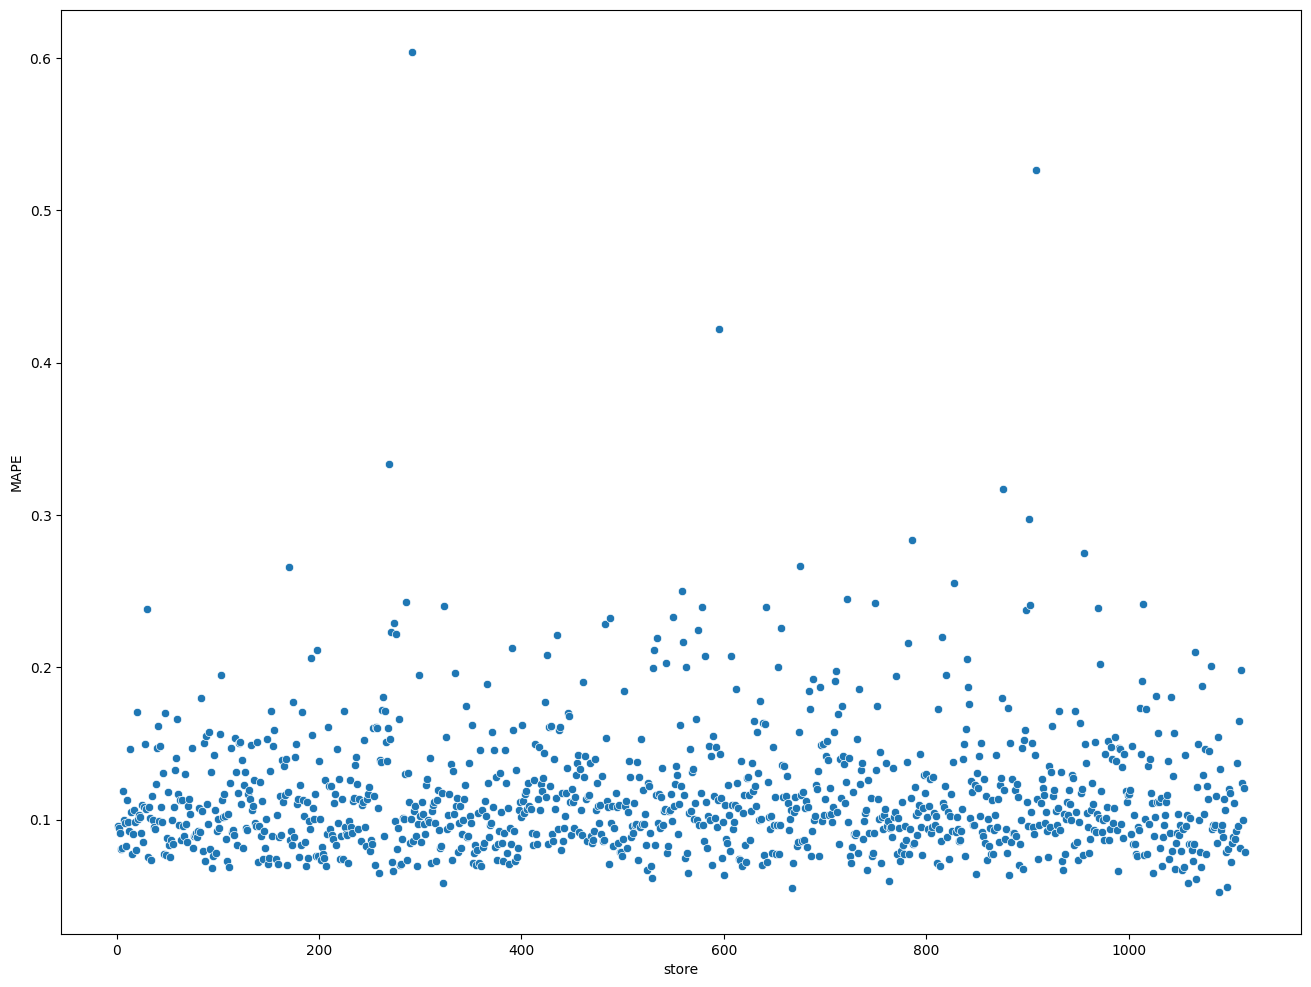

In [109]:
sb.scatterplot( x='store', y='MAPE', data=df92 );

## 9.2. Total Performance

The table below shows the CFO (stakeholder) the risk and forecast for Rossmann's stores. It is notable that the difference between the best and worst scenarios is not very high, approximately **1.5 million**, considering that on average, the values of the best and worst scenarios are in the range of **285.9 million**.

In [154]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'scenario', 0: 'values'} )
df93['values'] = df93['values'].map( '${:,.2f}'.format )
df93

,scenario,values
0,predictions,"$287,038,880.00"
1,worst_scenario,"$286,177,230.54"
2,best_scenario,"$287,900,483.44"


In [133]:
df92

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,175115.156250,174697.164933,175533.147567,417.991317,0.095609
1,2,181011.734375,180544.028941,181479.439809,467.705434,0.094444
2,3,268146.812500,267485.968836,268807.656164,660.843664,0.090955
3,4,342742.156250,341891.361724,343592.950776,850.794526,0.081067
4,5,170049.671875,169684.757450,170414.586300,364.914425,0.081617
...,...,...,...,...,...,...
1110,1111,195668.984375,194835.846389,196502.122361,833.137986,0.198180
1111,1112,338157.656250,337139.544381,339175.768119,1018.111869,0.124262
1112,1113,256748.406250,256113.266021,257383.546479,635.140229,0.099754
1113,1114,753685.437500,750906.175253,756464.699747,2779.262247,0.120918


## 9.3. Machine Learning Performance

In [111]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

/tmp/ipykernel_601/1385645114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
/tmp/ipykernel_601/1385645114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


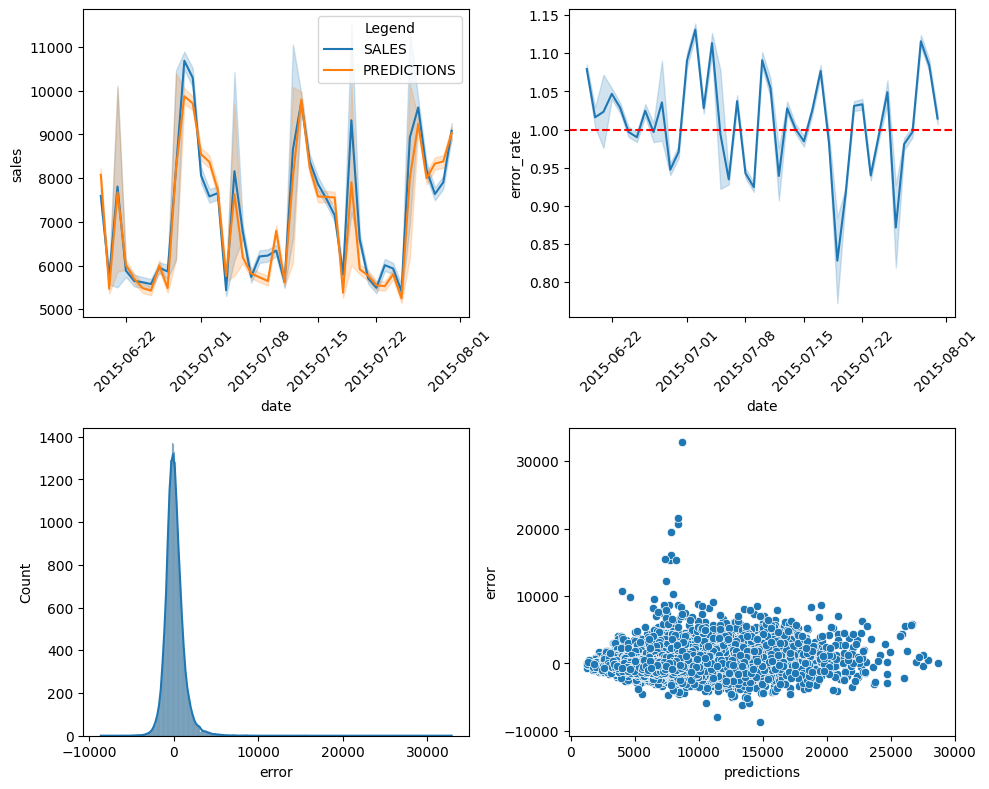

In [155]:
import seaborn as sb
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Line plots for sales and predictions
plt.subplot(2, 2, 1)
sb.lineplot(data=df9, x='date', y='sales', label='SALES')
sb.lineplot(data=df9, x='date', y='predictions', label='PREDICTIONS')
plt.legend(title='Legend')
plt.xticks(rotation=45)

# Line plot for error rate
plt.subplot(2, 2, 2)
sb.lineplot(data=df9, x='date', y='error_rate')
plt.axhline(1, linestyle='--', color='red')  # Highlighting the baseline error rate
plt.xticks(rotation=45)

# Histogram for error using histplot
plt.subplot(2, 2, 3)
sb.histplot(df9['error'], kde=True)  # 'kde=True' adds a kernel density estimate to smooth the histogram

# Scatter plot for predictions vs error
plt.subplot(2, 2, 4)
sb.scatterplot(data=df9, x='predictions', y='error')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plots


Analyzing the graphs above, which aim to show the performance of the machine learning model trained at this stage of the project, it is evident that **XGBoost** has shown excellent performance results already in the first CRISP-DM cycle, where a good approximation of the actual sales values was observed. Despite still being in the first phase of the cycle, this model can already be used as a solution for the sales forecasting problem, given that it is already capable of predicting sales for most stores with considerable accuracy.